# Zone Equalisation Normalisation - Tutorial

## About

This tutorial explains how to use the package [ZEN-norm](https://github.com/Genome-Function-Initiative-Oxford/ZEN-norm) - a set of tools for normalising genomic signals.

### Citation

T. Wilson, TA. Milne, SG. Riva and JR. Hughes, _Zone Equalisation Normalisation For Improved Alignment of Epigenetic Signal_, Unpublished, 2025

## Table of Content

1. [Imports and Set Up](#imports)
2. [ZEN Normalisation Quick Example](#quick-example)
3. [BAM to bigWig Mapping](#bam-to-bigwig)
4. [Reversing Prior bigWig Normalisation](#reverse-norm)
5. [Running ZEN Normalisation](#run-zen)
    1. [Specifying Input bigWigs](#run-zen-inputs)
    2. [Running ZEN Normalisation](#run-zen-convolution)
    3. [Distribution Fitting](#run-zen-distribution)
    4. [Signal Zone Prediction](#run-zen-zones)
    5. [Creating Normalised bigWigs](#run-zen-norm)
6. [Comparing Normalisation Method Performance Genome-Wide](#norm-compare)

## 1) Imports and Set Up <a id="imports"></a>

Import the ZEN-norm modules and other packages. If ZEN-norm is not installed, see the [GitHub page](https://github.com/Genome-Function-Initiative-Oxford/ZEN-norm).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from ZEN_norm_test.zone_norm import ZoneNorm
from ZEN_norm_test.reverse_norm import ReverseNorm
from ZEN_norm_test.compare_norm import CompareNorm

Set global parameters used throughout the notebook.

In [2]:
# Set working directory
os.chdir("/ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests")

# Max number of processors to use (set for your system)
cores = 12

# Coordinates of the human alpha globin locus
hg38_alpha_globin_coords = {"chrom": "chr16",
                            "start": 160000,
                            "end": 192000}

# Coordinates over the CCDC127 and SDHA genes
hg38_ccdc127_coords = {"chrom": "chr5",
                       "start": 193000,
                       "end": 262000}

mm10_sox2_coords = {"chrom": "chr3",
                   "start": 34643000,
                   "end": 34659244}

# 2) ZEN Normalisation Quick Example

A basic example is given below to create ZEN normalised bigWigs using the default parameters. Further explaination of the parameters, customisation and additional functionality is included in the rest of the tutorial.

In [3]:
# # EITHER create bigWigs without normalisation from BAMs
# ery_atac_znorm = ZoneNorm(analysis_name = "Erythroid_ATAC", # Name of output folder
#                           bam_paths = "/ceph/project/Wellcome_Discovery/datashare/towilson/Trackhubs/Human/Erythroid/50_Donors_Erythroid/hg38/Unpublished/ATAC/Replicates/BAMs", # List or directory of BAM files
#                           n_cores = cores, # Number of processors
#                           extend_reads = True, # Whether to extend reads during BAM to bigWig mapping
#                           filter_strand = False) # Whether to separate by strand (recommended to set as True for transcriptional assays)

# # OR set bigWigs directly
# ery_atac_znorm = ZoneNorm(analysis_name = "Erythroid_ATAC", # Name of output folder
#                           bigwig_paths = "/ceph/project/Wellcome_Discovery/datashare/towilson/Trackhubs/Human/Erythroid/50_Donors_Erythroid/hg38/Unpublished/ATAC/Replicates/Raw", # List or directory of bigWig files
#                           n_cores = cores) # Number of processors

# # Create smoothed signal
# ery_atac_znorm.convolveSignals()
# # Test Laplace distribution
# ery_atac_znorm.testDistributions()
# # Use distribution to predict signal zone coordinates
# ery_atac_znorm.predictSignalZones()
# # Create normalised bigWigs
# ery_atac_znorm.normaliseSignal()

## 3) BAM to bigWig Mapping <a id="bam-to-bigwig"></a>

ZEN-norm runs on genomic signals from either BAM or bigWig files. If you have BAMs, they first must be mapped to bigWigs. This can be done by `ZoneNorm` using the `bam_paths` parameter (see below). Ideally, run ZEN-norm on non-normalised bigWigs whenever possible. But if only pre-normalised bigWigs are available, see [Reversing Prior bigWig Normalisation](#reverse-norm).

### BAMs to Non-Normalised bigWigs for Non-Transcriptional Assays

For non-transcriptional assays (e.g. ATAC-seq or ChIP-seq), bigWigs can be generated from BAMs using a `ZoneNorm` object with the following key and optional parameters:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| **`analysis_name`** | Set a custom name for the output folder. | Default to saving results to a folder named `Analysis`. |
| **`bam_paths`** | Set as a list or directory of `.bam` files. | Required unless `bigwig_paths` is given (see [Running ZEN Normalisation](#run-zen)). |
| **`n_cores`** | The number of processors to use. | Defaults to use only one. |
| **`norm_method`** | Specifies how bigWig files are normalised. Set as `None` or `ZEN` to create non-normalised bigWigs at this stage (more steps are required to create ZEN normalised bigWigs) or as a deepTools normalisation method (`RPKM`, `CPM`, `BPM`, `RPGC`) to create bigWigs normalised with this (see `CompareNorm`). | Defaults to `ZEN`. |
| **`extend_reads`** | Set as `True` to enable read extension during bigWig creation | Defaults to `False`. |
| **`genome_size`** | Settable as an integer or the name of a genome, e.g. `hg38` or `mm10`. | Required only if using `RPGC` normalisation. |


##### Erythroid ATAC-seq Example <a id="bam-to-bigwig-ery-atac-example"></a>

In [4]:
ery_atac_output = "Erythroid_ATAC"
ery_atac_bams = "/ceph/project/Wellcome_Discovery/datashare/towilson/Trackhubs/Human/Erythroid/50_Donors_Erythroid/hg38/Unpublished/ATAC/Replicates/BAMs"

# Create bigWigs without normalisation to use as input for ZEN normalisation
ery_atac_znorm = ZoneNorm(analysis_name = ery_atac_output,
                          bam_paths = ery_atac_bams,
                          n_cores = cores,
                          norm_method = "ZEN",
                          extend_reads = True)

Opening 14 bigWig files
Setting chromosomes as autosomal and sex chromosomes


After creating a `ZoneNorm` object, it can be used again to normalise the bigWigs as explained in [Running ZEN Normalisation](#run-zen). Printing it displays information including:
| Name | Description |
|------------|-------------|
| Output directory | The output directory to store temporary files and results. |
| Chromosomes | Chromosomes to use for downstream analysis. Although all chromosomes are included in generated bigWigs, statistics calculated later will focus on this select subset. |
| Samples | Details about samples, including their number and names. |
| Blacklist path | Path to a blacklist if set. The blacklist is used to ignore regions of signal when calculating statistics downstream. |
| Kernel | Which kernel has been set for convolution (explained in [Signal Convolution](#run-zen-convolution)). |
| Distributions | Distributions to test and their parameters for separating signal from background (explained in [Distribution Fitting](#run-zen-distribution)). |
| Maximum cores | Maximum number of cores to use. |



In [5]:
# Optionally display information about the analysis
print(ery_atac_znorm)

ZoneNorm object for "Erythroid_ATAC"
   * Output directory: /ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/Erythroid_ATAC
   * 24 chromosome(s): chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX, chrY
   * Number of samples: 14
   * Sample names: Don002_ATAC_d13_rep1, Don002_ATAC_d13_rep2, Don002_ATAC_d13_rep3, Don002_ATAC_d13_rep4, Don002_ATAC_d13_rep5, Don002_ATAC_d13_rep6, Don002_ATAC_d13_rep7, Don003_ATAC_d13_rep1, Don003_ATAC_d13_rep2, Don003_ATAC_d13_rep3, Don003_ATAC_d13_rep4, Don003_ATAC_d13_rep5, Don003_ATAC_d13_rep6, Don003_ATAC_d13_rep7
   * Blacklist: Not set
   * Kernel: Triangle kernel of size 301
   * Test distributions: Laplace
   * Set distribution: Laplace with median fit, parameter type
   * Zone probabilty: 0.995
   * Resources: 12 cores
   * Verbose: 1 (silent)


Additionally, a region of genomic signal can be visualised using method `plotTracks`.

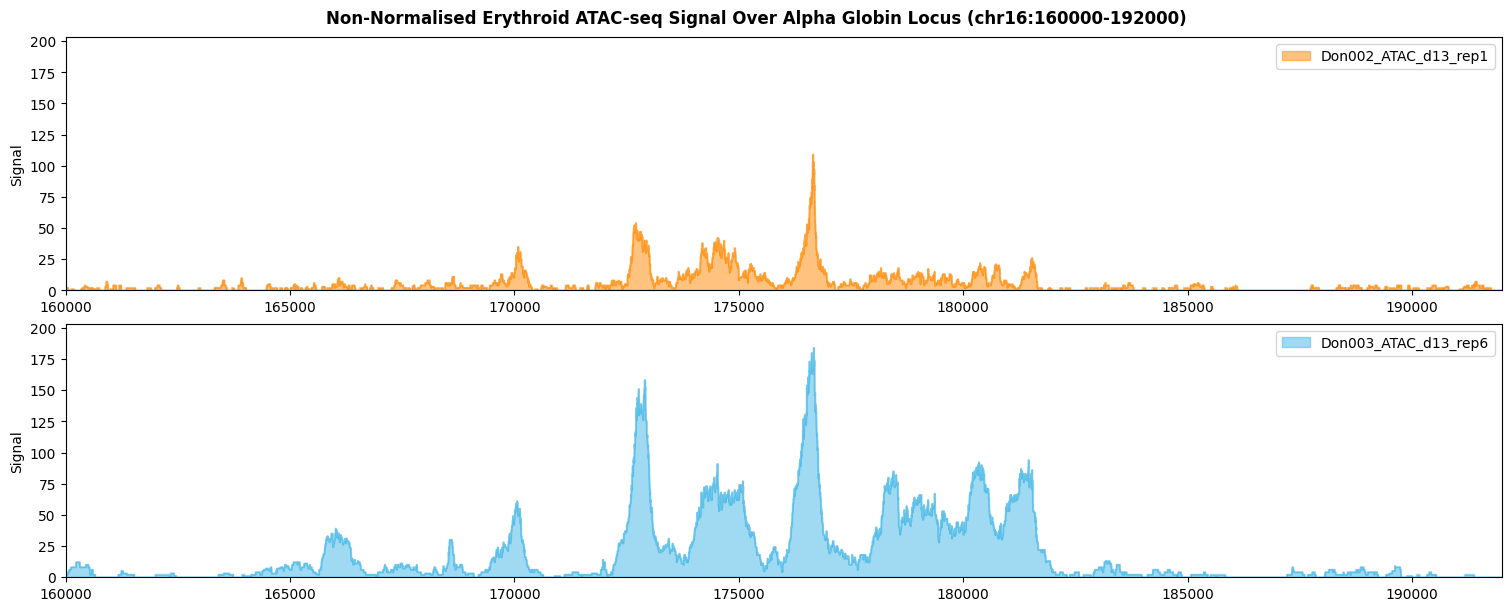

In [6]:
# Plot the raw signal for two samples
title = f"Non-Normalised Erythroid ATAC-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

ery_atac_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                          start_coord = hg38_alpha_globin_coords["start"],
                          end_coord = hg38_alpha_globin_coords["end"],
                          plot_samples = ["Don002_ATAC_d13_rep1", "Don003_ATAC_d13_rep6"],
                          custom_colours = ["#FF8800", "#41B6E6"],
                          overlay_plots = False,
                          main_title = title)

### BAMs to Non-Normalised bigWigs for Transcriptional Assays

For transcriptional assays (e.g. TT-seq), bigWigs can be generated from BAMs in a similar way to ATAC-seq or ChIP-seq (see [Erythroid ATAC-seq Example](#bam-to-bigwig-ery-atac-example)). An additional parameter can be useful to split signal into forward (positive) and reverse (negative) strands:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `filter_strand` | Setting this as `True` will split a BAM into forward and reverse strand bigWigs, or setting `forward` or `reverse` will keep only one strand. | Defaults to `False` which disables strand filtering. | 


##### HeLA TT-seq Example

In [7]:
# Create bigWigs without normalisation to use as input for ZEN normalisation
hela_ttseq_znorm = ZoneNorm(analysis_name = "HeLa_TTseq",
                            bam_paths = "/ceph/project/Wellcome_Discovery/datashare/towilson/Trackhubs/Human/Cervical_Carcinoma/HeLa_TT-seq_A_Fiszbein_2024/hg38/BAMs",
                            n_cores = cores,
                            norm_method = "ZEN",
                            filter_strand = True,
                            extend_reads = False)

Opening 12 bigWig files
Setting chromosomes as autosomal and sex chromosomes


In [8]:
# Optionally display information about the analysis
print(hela_ttseq_znorm)

ZoneNorm object for "HeLa_TTseq"
   * Output directory: /ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/HeLa_TTseq
   * 24 chromosome(s): chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX, chrY
   * Number of samples: 12
   * Sample names: HeLa_TTseq_Control_Rep1_Pos, HeLa_TTseq_Control_Rep1_Neg, HeLa_TTseq_Control_Rep2_Pos, HeLa_TTseq_Control_Rep2_Neg, HeLa_TTseq_Control_Rep3_Pos, HeLa_TTseq_Control_Rep3_Neg, HeLa_TTseq_U1AMO_Rep1_Pos, HeLa_TTseq_U1AMO_Rep1_Neg, HeLa_TTseq_U1AMO_Rep2_Pos, HeLa_TTseq_U1AMO_Rep2_Neg, HeLa_TTseq_U1AMO_Rep3_Pos, HeLa_TTseq_U1AMO_Rep3_Neg
   * Blacklist: Not set
   * Kernel: Triangle kernel of size 301
   * Test distributions: Laplace
   * Set distribution: Laplace with median fit, parameter type
   * Zone probabilty: 0.995
   * Resources: 12 cores
   * Verbose: 1 (silent)


View the strand separated signal using `plotTracks`.

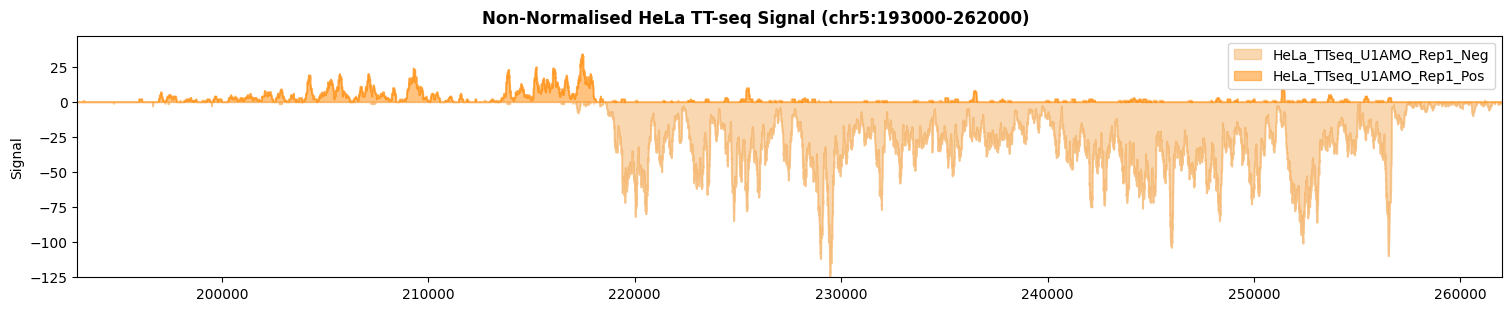

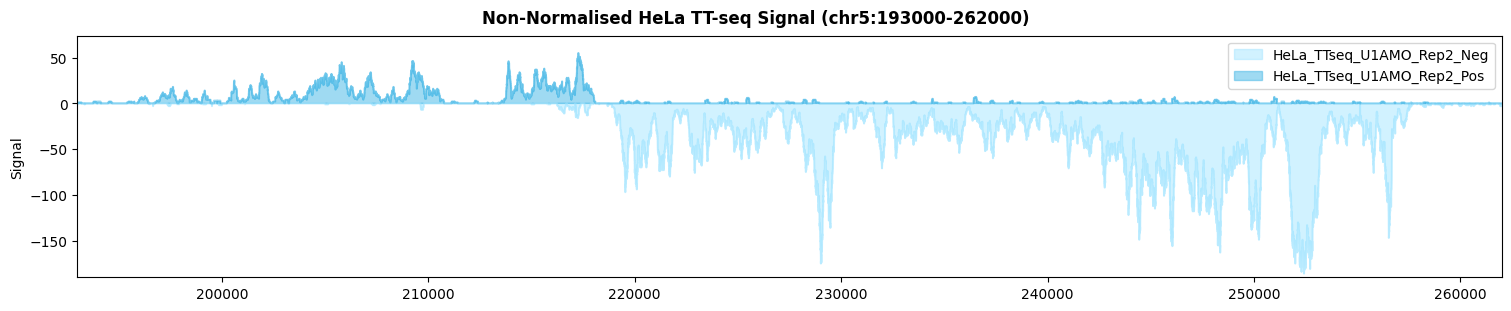

In [9]:
# Plot the raw signal
title = f"Non-Normalised HeLa TT-seq Signal "
title += f"({hg38_ccdc127_coords['chrom']}:{hg38_ccdc127_coords['start']}-{hg38_ccdc127_coords['end']})"

hela_ttseq_znorm.plotTracks(chromosome = hg38_ccdc127_coords["chrom"],
                            start_coord = hg38_ccdc127_coords["start"],
                            end_coord = hg38_ccdc127_coords["end"],
                            plot_samples = ["HeLa_TTseq_U1AMO_Rep1_Pos", "HeLa_TTseq_U1AMO_Rep1_Neg"],
                            custom_colours = ["#F5B265", "#FF8800"],
                            overlay_plots = True,
                            main_title = title)

hela_ttseq_znorm.plotTracks(chromosome = hg38_ccdc127_coords["chrom"],
                            start_coord = hg38_ccdc127_coords["start"],
                            end_coord = hg38_ccdc127_coords["end"],
                            plot_samples = ["HeLa_TTseq_U1AMO_Rep2_Pos", "HeLa_TTseq_U1AMO_Rep2_Neg"],
                            custom_colours = ["#A5E6FF", "#41B6E6"],
                            overlay_plots = True,
                            main_title = title)

## 4) Reversing Prior bigWig Normalisation <a id="reverse-norm"></a>

If BAMs are not avaliable, then non-normalised bigWigs may be created from pre-normalised bigWigs. This can be done after any linear normalisation method (such as RPKM, CPM) using the `ReverseNorm` module. 

##### Publically Downloaded mESC ATAC-seq bigWigs Example

To initialise a `ReverseNorm` instance, set the following parameters:
| Parameter | Description | Usage |
|------------|-------------|-------------|
| `analysis_name` | Set as the name of the output folder. | Default to saving results to a folder named `Analysis`. | 
| `bigwig_paths` | Set as a list or directory of `.bw` and/or `.bigWig` files. | Required unless `bam_paths` is given (see [BAM to bigWig Mapping](#bam-to-bigwig)). |
| `n_cores` | Number of processors to use. | Defaults to use only one. |


In [10]:
# Set parameters for reverse normalisation
mesc_rev = ReverseNorm(analysis_name = "mESC_ATAC",
                       bigwig_paths = ["/ceph/project/Wellcome_Discovery/towilson/Datasets/Mouse/mESC/E14_to_EB_H3K27ac/mm10/bigWigs/E14_ATAC_RA.bw", "/ceph/project/Wellcome_Discovery/towilson/Datasets/Mouse/mESC/E14_to_EB_H3K27ac/mm10/bigWigs/E14_ATAC_LIF.bw"],
                       n_cores = cores)

Opening 2 bigWig files
Setting chromosomes as autosomal and sex chromosomes


Like with a `ZoneNorm` object, method `plotTracks` can optionally be used to view part of the genomic signal. 

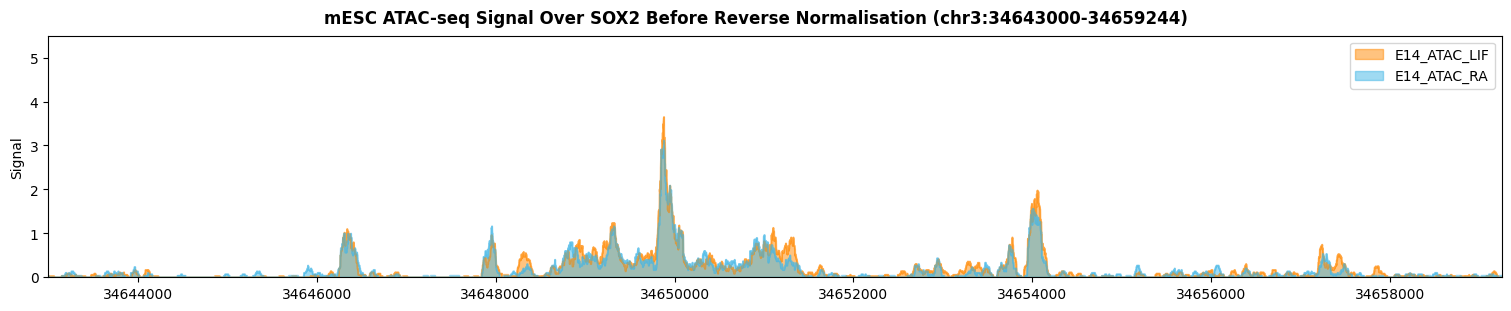

In [11]:
# Plot part of the original signal
title = f"mESC ATAC-seq Signal Over SOX2 Before Reverse Normalisation "
title += f"({mm10_sox2_coords['chrom']}:{mm10_sox2_coords['start']}-{mm10_sox2_coords['end']})"

mesc_rev.plotTracks(chromosome = mm10_sox2_coords["chrom"],
                    start_coord = mm10_sox2_coords["start"],
                    end_coord = mm10_sox2_coords["end"],
                    plot_samples = ["E14_ATAC_LIF", "E14_ATAC_RA"],
                    custom_colours = ["#FF8800", "#41B6E6"],
                    overlay_plots = True,
                    main_title = title)

Run the method `runReversal` to create reverse normalised bigWigs. This works through estimating the value of one read fragment per bigWig, then dividing signal from all chromosomes by this. All parameters are optional, but the following are worth noting:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `chromosomes` | A list of chromosomes to estimate fragment size from. Generally a small chromosome is sufficient as this will speed up fragment size estimation, but by default all chromosomes will be used if not set. | Not required, but can reduce run time. |
| `replace_existing` | If set as `True`, any existing output files generated by this method will be recreated. This is useful if a previous run was interrupted and produced incomplete or corrupt files. If `False` (default), only missing files will be generated without overwriting existing ones. | Use only to recreate files after a previous run. |


In [12]:
# Perform reverse normalisation, using a small chromosome for fragment size estimation
mesc_rev.runReversal(chromosomes = ["chr19"])

Reverse normalised bigWigs already created for all samples


## 5) Running ZEN Normalisation <a id="run-zen"></a>

Once you have access to bigWigs (ideally non-normalised), you can ZEN normalise them in several steps using the `ZoneNorm` module. 

### 5.1) Specifying Input bigWigs <a id="run-zen-inputs"></a>

If you have used `ZoneNorm` to map BAMs to bigWigs, the same `ZoneNorm` instance can be used as the parameters and path to bigWigs have already been set. Otherwise, a new `ZoneNorm` object needs to be created using parameter `bigwig_paths` instead of `bam_paths` to set bigwigs as input rather than BAMs:
| Parameter | Description | Usage |
|------------|-------------|-------------|
| `analysis_name` | Set a custom name for the output folder. | Default to saving results to a folder named `Analysis`. |
| `bigwig_paths` | Set as a list or directory of `.bw` and/or `.bigWig` files. | Required unless `bam_paths` is given (see [BAM to bigWig Mapping](#bam-to-bigwig)). |
| `n_cores` | The number of processors to use. | Defaults to use only one. |
| `norm_method` | Specifies how bigWig files are normalised. Set as `None` or `ZEN` to create non-normalised bigWigs at this stage (more steps are required to create ZEN normalised bigWigs) or as a deepTools normalisation method (`RPKM`, `CPM`, `BPM`, `RPGC`) to create bigWigs normalised with this (see `CompareNorm`). | Defaults to `ZEN`. |

##### Erythroid RAD21 ChIP-seq Example

In [13]:
# Set pre-existing bigWigs for downstream analysis
rad21_chip_znorm = ZoneNorm(analysis_name = "Erythroid_RAD21_ChIPseq",
                            bigwig_paths = "/ceph/project/Wellcome_Discovery/datashare/towilson/Trackhubs/Human/Erythroid/50_Donors_Erythroid/hg38/E_Georgiades_2025/RAD21/Raw",
                            n_cores = cores,
                            norm_method = "ZEN",
                            extend_reads = True)

Opening 8 bigWig files
Setting chromosomes as autosomal and sex chromosomes


In [14]:
print(rad21_chip_znorm)

ZoneNorm object for "Erythroid_RAD21_ChIPseq"
   * Output directory: /ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/Erythroid_RAD21_ChIPseq
   * 24 chromosome(s): chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX, chrY
   * Number of samples: 8
   * Sample names: Don001_RAD21_d13_rep1, Don001_RAD21_d13_rep2, Don001_RAD21_d13_rep3, Don002_RAD21_d13_rep1, Don002_RAD21_d13_rep2, Don002_RAD21_d13_rep3, Don030_RAD21_d13_rep1, Don030_RAD21_d13_rep3
   * Blacklist: Not set
   * Kernel: Triangle kernel of size 301
   * Test distributions: Laplace
   * Set distribution: Laplace with median fit, parameter type
   * Zone probabilty: 0.995
   * Resources: 12 cores
   * Verbose: 1 (silent)


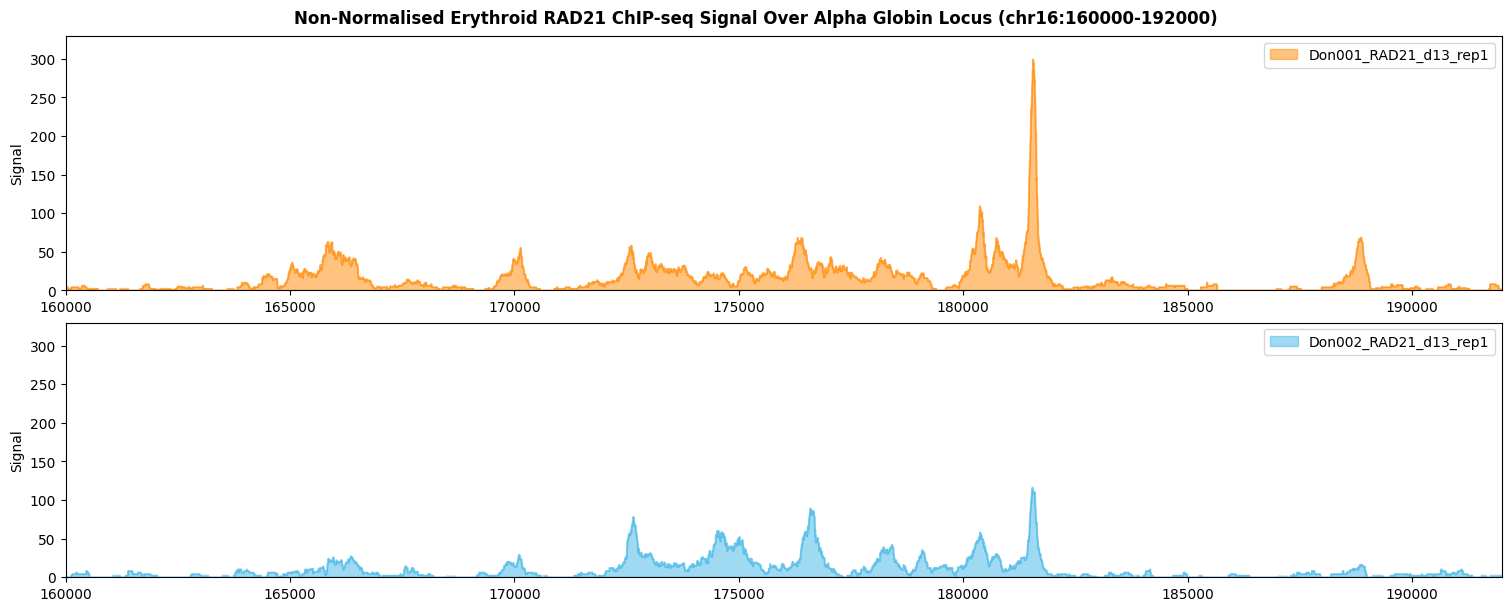

In [15]:
# Plot the raw signal
title = f"Non-Normalised Erythroid RAD21 ChIP-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

rad21_chip_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                            start_coord = hg38_alpha_globin_coords["start"],
                            end_coord = hg38_alpha_globin_coords["end"],
                            plot_samples = ["Don001_RAD21_d13_rep1", "Don002_RAD21_d13_rep1"],
                            custom_colours = ["#FF8800", "#41B6E6"],
                            overlay_plots = False,
                            main_title = title)

##### Reverse Normalised bigWigs Example

In [16]:
# Initialise with reverse normalised bigWigs
mesc_atac_znorm = ZoneNorm(analysis_name = "mESC_ATAC",
                           bigwig_paths = "/ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/mESC_ATAC/Results/Reverse_Normalised/BigWigs",
                           n_cores = cores,
                           norm_method = "ZEN")

Opening 2 bigWig files
Setting chromosomes as autosomal and sex chromosomes


In [17]:
print(mesc_atac_znorm)

ZoneNorm object for "mESC_ATAC"
   * Output directory: /ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/mESC_ATAC
   * 21 chromosome(s): chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chrX, chrY
   * Number of samples: 2
   * Sample names: E14_ATAC_LIF_reverse_norm, E14_ATAC_RA_reverse_norm
   * Blacklist: Not set
   * Kernel: Triangle kernel of size 301
   * Test distributions: Laplace
   * Set distribution: Laplace with median fit, parameter type
   * Zone probabilty: 0.995
   * Resources: 12 cores
   * Verbose: 1 (silent)


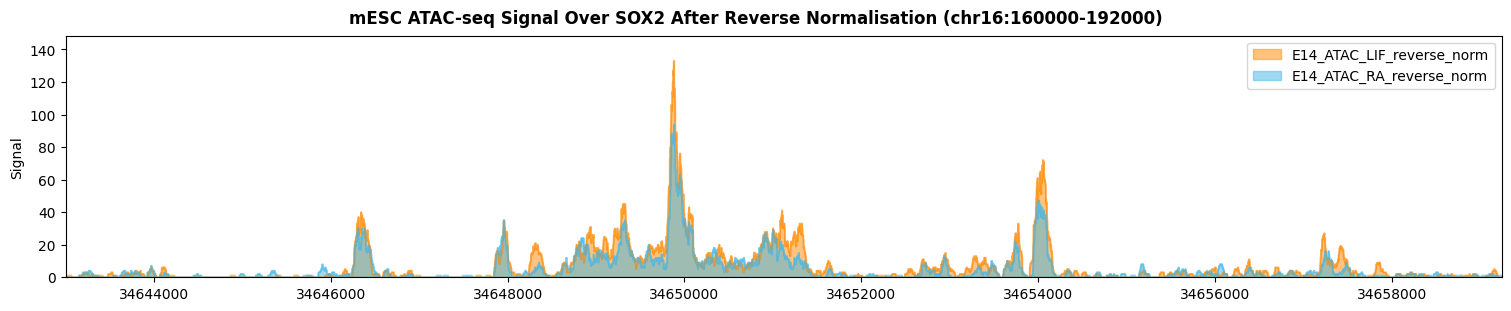

In [18]:
# Plot signal after reverse normalisation
title = f"mESC ATAC-seq Signal Over SOX2 After Reverse Normalisation "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

mesc_atac_znorm.plotTracks(chromosome = mm10_sox2_coords["chrom"],
                           start_coord = mm10_sox2_coords["start"],
                           end_coord = mm10_sox2_coords["end"],
                           plot_samples = ["E14_ATAC_LIF_reverse_norm", "E14_ATAC_RA_reverse_norm"],
                           custom_colours = ["#FF8800", "#41B6E6"],
                           overlay_plots = True,
                           main_title = title)

### 5.2) Signal Convolution <a id="run-zen-convolution"></a>

After initialising a `ZoneNorm` object, the next step is to calculate statistics about the signal per sample and chromosome and to create a smoothed version of this signal via convolution. The smoothed signal helps separate biological signal from noise by reducing the influence of local fluctuations, but is not used beyond [Signal Zone Prediction](#run-zen-zones).

#### Default Smoothing Kernel

The recommended smoothing kernel is a 301 base pair triangular kernel, which is set by default when a `ZoneNorm` instance is initialised.

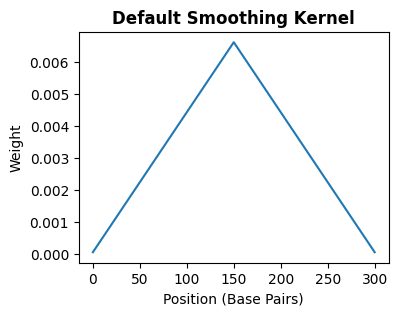

In [19]:
# Get the default 301 base-pair triangle kernel
default_kernel = ZoneNorm.createTriangleKernel(size = 301)

# View the smoothing kernel
plt.figure(figsize = (4, 3))
plt.plot(default_kernel)
plt.title("Default Smoothing Kernel", fontweight = "bold")
plt.xlabel("Position (Base Pairs)")
plt.ylabel("Weight")
plt.show()

#### Creating a Custom Kernel

A custom kernel can also be applied for signal smoothing, represented as a list or array of values. To override the default kernel, a new one can be set either during initialisation of a `ZoneNorm` instance using parameter `kernel`, or after using the method `setKernel`. In either case:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `kernel` | Set as a numerical list or array representing a kernel. | Defaults to a 301 base pair triangular kernel. |


##### Gaussian Kernel Example

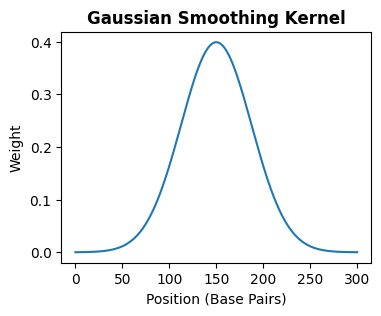

In [20]:
# Set mean and standard deviation
mu = 0
sigma = 1
# Kernel size
n_bps = 301

# Create normal distribution kernel
gaussian_kernel = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.linspace(mu - 4 * sigma, mu + 4 * sigma, n_bps) - mu) / sigma) **2)

# Set kernel after initialisation
mesc_atac_znorm.setKernel(gaussian_kernel)

# View the set kernel
mesc_atac_znorm.plotKernel(title = "Gaussian Smoothing Kernel")

In [21]:
print(mesc_atac_znorm)

ZoneNorm object for "mESC_ATAC"
   * Output directory: /ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/mESC_ATAC
   * 21 chromosome(s): chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chrX, chrY
   * Number of samples: 2
   * Sample names: E14_ATAC_LIF_reverse_norm, E14_ATAC_RA_reverse_norm
   * Blacklist: Not set
   * Kernel: Custom kernel of size 301
   * Test distributions: Laplace
   * Set distribution: Laplace with median fit, parameter type
   * Zone probabilty: 0.995
   * Resources: 12 cores
   * Verbose: 1 (silent)


#### Running Signal Convolution

Once the kernel is set (or left unset to use the default), the method `convolveSignals` should be run. No parameters need to be specified when calling this method. However, the following are worth noting:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `chromosomes` | List or array of chromosomes to run convolution for. | By default, all chromosomes are used. Setting a single chromosome, e.g. `["chr19"]`, can be helpful to verify that the step completes successfully. |
| `replace_existing` | If set as `True`, any existing output files generated by this method will be recreated. This is useful if a previous run was interrupted and produced incomplete or corrupt files. If `False` (default), only missing files will be generated without overwriting existing ones. | Use only to recreate files after a previous run. |

##### Erythroid ATAC-seq Example

In [22]:
# Create smoothed signal for erythroid ATAC-seq
ery_atac_znorm.convolveSignals()

Signal, smoothed signal and missing signal already created for chromosomes


##### Erythroid RAD21 ChIP-seq Example

In [23]:
# Create smoothed signal for erythroid RAD21 ChIP-seq
rad21_chip_znorm.convolveSignals()

Signal, smoothed signal and missing signal already created for chromosomes


##### HeLA TT-seq Example

In [24]:
# Create smoothed signal for erythroid HeLa cell TT-seq
hela_ttseq_znorm.convolveSignals()

Signal, smoothed signal and missing signal already created for chromosomes


##### mESC ATAC-seq Example

In [25]:
# Create smoothed signal for mESC ATAC-seq
mesc_atac_znorm.convolveSignals()

Signal, smoothed signal and missing signal already created for chromosomes


#### Retrieving Signal Statistics

When running `convolveSignals`, statistics are calculated about the signal per sample and chromosome. These can be retrieved using the method `getSignalStats`, and include the following metrics:
| Statistic | Description |
|------------|-------------|
| fragmentEstimate | Smallest non-zero value to represent the predicted value a signal produces from a single read. |
| coverage | Number of base pairs with non-zero signal. |
| sum | Sum total of all signal. |
| mean | Signal mean. |
| median | Signal median. |
| SD | Signal standard deviation. |
| MAD | Signal median average deviation. |
| meanAD | Signal mean average deviation. |


In [26]:
# Show statistics calculated per sample and chromosome
ery_atac_znorm.getSignalStats()

,sample,chrom,signal_type,fragmentEstimate,coverage,sum,mean,median,SD,MAD,meanAD
0,Don002_ATAC_d13_rep1,chr1,signal,1.000000,91675301,356723264.0,1.432874,0.000000,80.314110,0.000000,1.831018
1,Don002_ATAC_d13_rep1,chr1,signal_non_zero,1.000000,91675301,356723264.0,3.891160,2.000000,132.314896,0.000000,2.871660
2,Don002_ATAC_d13_rep1,chr1,signal_unpadded_sample_zones,9.000000,847408,21436040.0,25.296009,19.000000,16.441071,7.000000,12.627263
3,Don002_ATAC_d13_rep1,chr1,signal_padded_sample_zones,2.000000,4163164,21862552.0,5.251427,4.000000,3.996745,2.000000,3.091710
4,Don002_ATAC_d13_rep1,chr1,signal_unpadded_merged_zones,2.000000,3769752,23731664.0,6.295285,5.000000,4.382790,3.000000,3.432275
...,...,...,...,...,...,...,...,...,...,...,...
2025,Don003_ATAC_d13_rep7,chrY,signal_transformed,-10.034559,300,105522288.0,0.132605,0.425339,1.438289,0.665569,1.000608
2026,Don003_ATAC_d13_rep7,chrY,signal_unpadded_sample_zones,14.000000,131800,4888050.0,37.086876,37.000000,14.686647,13.000000,12.662354
2027,Don003_ATAC_d13_rep7,chrY,signal_padded_sample_zones,2.000000,301458,4762374.0,15.797803,9.000000,15.037323,6.000000,12.500481
2028,Don003_ATAC_d13_rep7,chrY,signal_unpadded_merged_zones,3.000000,258632,5000484.0,19.334360,13.000000,15.686055,8.000000,13.378141


#### Saving Convoluted Signal to bigWigs

If you want to save these smoothed signals to bigWigs (e.g. for visualisation in a genome browser, or to use for a different analysis), the method `createSmoothBigWigs` can be used.

In [27]:
# # Optionally save convolved signals to bigWig
# ery_atac_znorm.createSmoothBigWigs()

#### Visualising Convoluted Signal

A region of the smoothed signal can be visualised by passing in custom signals to the `plotTracks` method. 

Reading chr16:0-90338345 for Don002_ATAC_d13_rep1
Reading chr16:0-90338345 for Don002_ATAC_d13_rep1


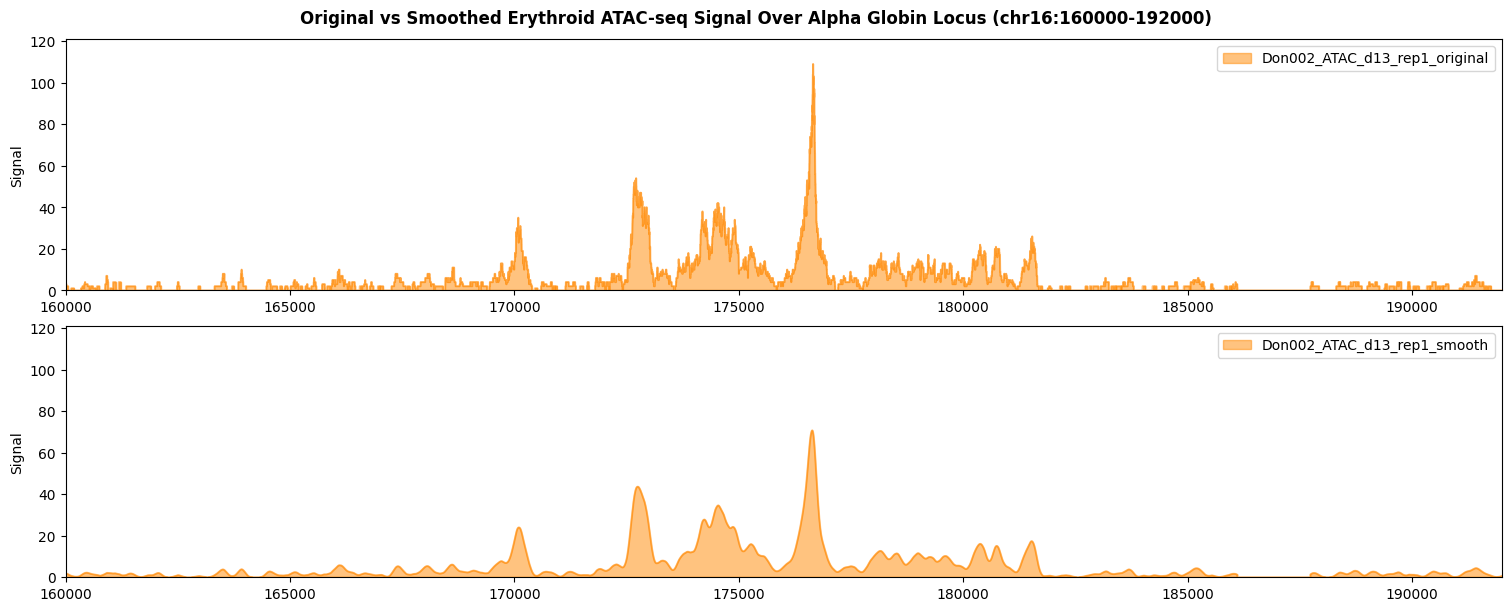

In [28]:
# Get signal before and after convolution over the alpha globin locus
ery_original_signal = ery_atac_znorm.getOriginalSignal(sample = "Don002_ATAC_d13_rep1", chromosome = hg38_alpha_globin_coords["chrom"])
ery_smooth_signal = ery_atac_znorm.getSmoothedSignal(sample = "Don002_ATAC_d13_rep1", chromosome = hg38_alpha_globin_coords["chrom"])

# Plot the raw signal for two samples 
title = f"Original vs Smoothed Erythroid ATAC-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

ery_atac_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                          start_coord = hg38_alpha_globin_coords["start"],
                          end_coord = hg38_alpha_globin_coords["end"],
                          signals = {"Don002_ATAC_d13_rep1_original": ery_original_signal, "Don002_ATAC_d13_rep1_smooth": ery_smooth_signal},
                          custom_colours = ["#FF8800", "#FF8800"],
                          overlay_plots = False,
                          main_title = title)

### 5.3) Distribution Fitting <a id="run-zen-distribution"></a>

After signal convolution, the next step is fitting distributions to the smoothed signal using method `testDistributions`. This uses the Kolmogorov–Smirnov test to measure how well each distribution fits when its location and scale parameters are based on the either the mean and standard deviation (SD), median and mean average deviation (MAD) or derived from SciPy. The aim is to determine which distribution and parameter combination to use as a 'zone threshold' for separating signal from background noise.

#### Using The Default Distribution (Recommended)

By default, `ZoneNorm` tests only the Laplace distribution. This generalises well across assays and it is sufficient for most analyses. If you want to use this default, skip to [Signal Zone Prediction](#run-zen-zones).

In [29]:
# Calculate parameters of Laplace fitted to the smoothed signal, alongside stats quantifying its fit
mesc_atac_znorm.testDistributions()

Distribution statistics already calculated for chromosomes


Statistics calculated per chromosome for each sample, distribution and parameter type can be retrieved using the method `getDistributionStats`. 

In [30]:
# Show distribution fitting statistics (sorted by Kolmogorov-Smirnov)
mesc_atac_znorm.getDistributionStats().sort_values(by = "KS_stat", ascending = False)

,sample,chrom,distribution,param_type,AIC,BIC,KS_p_value,KS_stat,location,log_likelihood,scale
109,E14_ATAC_RA_reverse_norm,chr16,laplace,mean_fit,1092.900550,1100.308114,0.000139,0.125578,-0.898014,-544.450275,1.250685
124,E14_ATAC_RA_reverse_norm,chrY,laplace,mean_fit,1010.699858,1018.107423,0.000808,0.113448,-1.063373,-503.349929,1.135522
121,E14_ATAC_RA_reverse_norm,chrX,laplace,mean_fit,1082.151770,1089.559335,0.001457,0.109070,-0.966393,-539.075885,1.218105
123,E14_ATAC_RA_reverse_norm,chrY,laplace,scipy_fit,1003.952360,1011.359925,0.007698,0.095646,-1.056069,-499.976180,0.973790
37,E14_ATAC_LIF_reverse_norm,chr13,laplace,mean_fit,1092.895707,1100.303272,0.009764,0.093571,-0.824516,-544.447854,1.238087
...,...,...,...,...,...,...,...,...,...,...,...
29,E14_ATAC_LIF_reverse_norm,chr10,laplace,median_fit,1077.824877,1085.232442,0.764531,0.037996,-0.510201,-536.912438,1.052691
99,E14_ATAC_RA_reverse_norm,chr13,laplace,scipy_fit,1054.424396,1061.831961,0.797583,0.036782,-0.751493,-525.212198,1.059249
63,E14_ATAC_RA_reverse_norm,chr1,laplace,scipy_fit,944.848463,952.256027,0.831523,0.035469,-0.701045,-470.424231,0.882438
86,E14_ATAC_RA_reverse_norm,chr8,laplace,median_fit,1035.471673,1042.879238,0.854415,0.034529,-0.648325,-515.735836,0.924777


#### Testing Additional Distributions

While the Laplace distribution fit based on the median is recommended, `ZenNorm` supports any two parameter SciPy distribution (Normal, Laplace, Logistic, Cauchy, left skewed Gumbell and right skewed Gumbel). To get the names of these distributions, method `getSupportedDistributions` can be used.

In [31]:
# View all supported distributions
print(ZoneNorm.getSupportedDistributions())

['norm', 'laplace', 'logistic', 'cauchy', 'gumbel_l', 'gumbel_r']


A custom list of distributions can then be specified either during initialisation of the `ZoneNorm` object, or using method `setTestDistributions`. In either case:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `test_distributions` | List of statistical distributions to evaluate by their fit to the smoothed signal. | Set only if you want to evalulate additional distributions. By default, only Laplace is tested as this is suitable for most datasets. |


##### Erythroid ATAC-seq Example

In [32]:
# Set to test additional distributions
ery_atac_znorm.setTestDistributions(test_distributions = ["norm", "logistic", "laplace", "gumbel_l", "gumbel_r", "cauchy"])
# Run to test these distributions
ery_atac_znorm.testDistributions()

Distribution statistics already calculated for chromosomes


##### Erythroid RAD21 ChIP-seq Example

In [33]:
# Set to test additional distributions
rad21_chip_znorm.setTestDistributions(test_distributions = ["norm", "logistic", "laplace", "gumbel_l", "gumbel_r", "cauchy"])
# Run to test these distributions
rad21_chip_znorm.testDistributions()

Distribution statistics already calculated for chromosomes


##### HeLa TT-seq Example

In [34]:
# Set to test additional distributions
hela_ttseq_znorm.setTestDistributions(test_distributions = ["norm", "logistic", "laplace", "gumbel_l", "gumbel_r", "cauchy"])
# Run to test these distributions
hela_ttseq_znorm.testDistributions()

Distribution statistics already calculated for chromosomes


#### Quantile-Quantile Plots

To compare how well each distribution fits for sample over a chromosome, Q-Q plots can be created using the method `plotQQPlot`. Key parameters include:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `plot_sample` | Name of sample to create QQ plot for. | Required. |
| `chromosome` | Name of chromosome that distribution was fitted to signal for. | Required. |
| `param_type` | Determines which parameter set to use for each distribution's location and scale. Options include `mean_fit` (mean and SD), `median_fit` (median and MAD), `scipy_fit` (SciPy's recommended parameters) or `infer`. | Required. |
| `pdf_name` | If provided, the plot will be saved as a PDF file with this name. | By default, plot is displayed but not saved. |



In each plot, a red line represent the expected theoretical quantiles of a distribution, while blue dots show the relationship between the theoretical and the observed quantiles of the smoothed signal. The closer the points align with the red line, the better the fit of the distribution.

##### Erythroid ATAC-seq Example

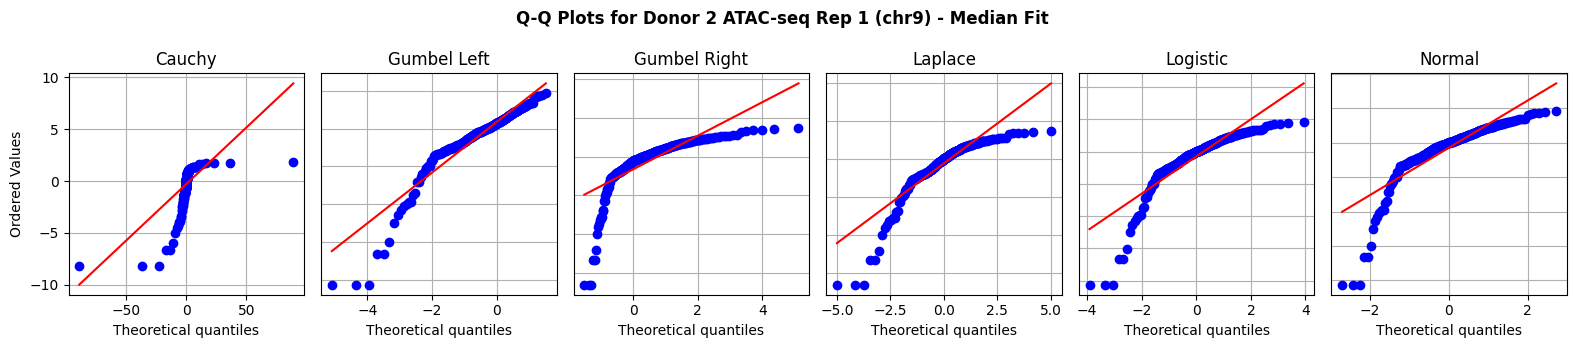

In [35]:
# Create QQ plots for erythroid ATAC-seq
sample_name = "Don002_ATAC_d13_rep1"
chromosome = "chr9"

ery_atac_znorm.plotQQPlot(plot_sample = sample_name,
                          chromosome = chromosome,
                          param_type = "median_fit",
                          plot_width = 16,
                          plot_height = 3.5,
                          title = f"Q-Q Plots for Donor 2 ATAC-seq Rep 1 ({chromosome}) - Median Fit",
                          pdf_name = f"{sample_name}_QQ_Plots")

##### Erythroid RAD21 ChIP-seq Example

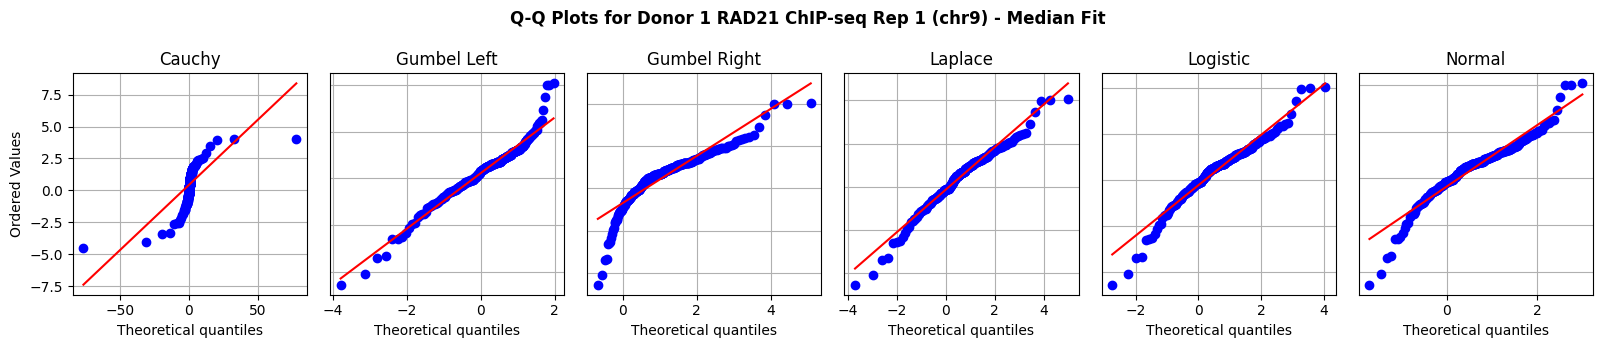

In [36]:
# Create QQ plots for erythroid RAD21 ChIP-seq
sample_name = "Don001_RAD21_d13_rep1"
chromosome = "chr9"

rad21_chip_znorm.plotQQPlot(plot_sample = sample_name,
                          chromosome = chromosome,
                          param_type = "median_fit",
                          plot_width = 16,
                          plot_height = 3.5,
                          title = f"Q-Q Plots for Donor 1 RAD21 ChIP-seq Rep 1 ({chromosome}) - Median Fit",
                          pdf_name = f"{sample_name}_QQ_Plots")

##### HeLa TT-seq Example

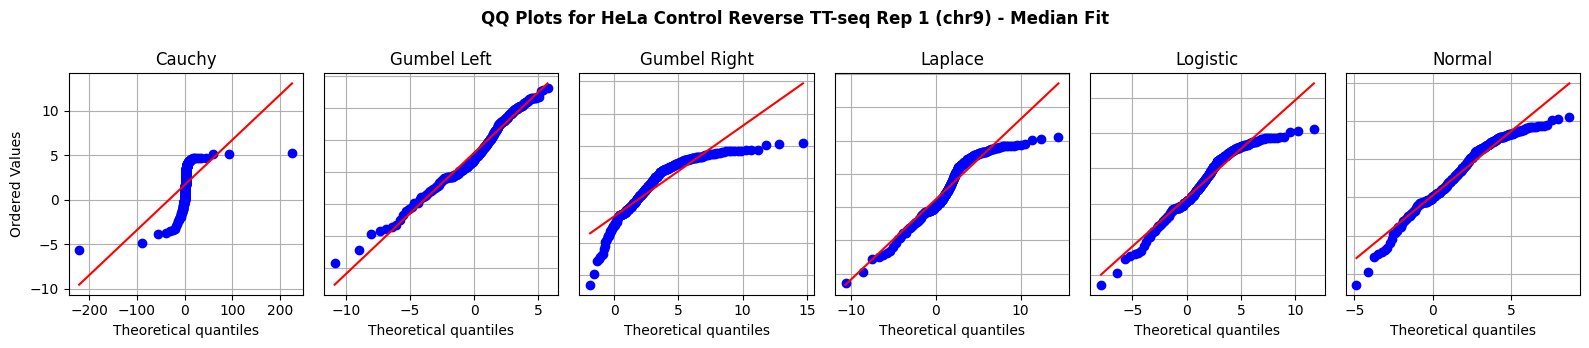

In [37]:
# Create QQ plots for HeLa TT-seq
sample_name = "HeLa_TTseq_Control_Rep1_Neg"
chromosome = "chr9"

hela_ttseq_znorm.plotQQPlot(plot_sample = sample_name,
                          chromosome = chromosome,
                          param_type = "median_fit",
                          plot_width = 16,
                          plot_height = 3.5,
                          title = f"QQ Plots for HeLa Control Reverse TT-seq Rep 1 ({chromosome}) - Median Fit",
                          pdf_name = f"{sample_name}_QQ_Plots")

#### Distribution Fit Plots

A more effective way to assess how well each distribution fits the data is to visualise histograms of the chromosome signal (after smoothing and log transformation) overlaid with the fitted distributions. This can be done using method `plotDistributionFit` with the following key parameters:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `plot_sample` | Name of sample to create distribution fit plot for. | Required. |
| `chromosome` | Name of chromosome that distribution was fitted to signal for. | Required. |
| `plot_distributions` | List of distributions to include on each sub-plot. | By default, all distributions are plotted. |
| `plot_param_types` | List of location and scale parameter types. One sub-plot will be created per type. Options include `mean_fit` (mean and SD), `median_fit` (median and MAD), and `scipy_fit` (SciPy's recommended parameters). | By default, all parameter types are plotted. |
| `pdf_name` | If provided, the plot will be saved as a PDF file with this name. | By default, plot is displayed but not saved. |

While QQ plots are helpful for comparing different distribution types, the distribution fit plots provide a clearer view of how well the location and scale parameters capture the shape of the observed signal. These plots also display log transformed zone thresholds, showing the cutoff points in the histogram where the signal is separated from the background.

##### Erythroid ATAC-seq Example

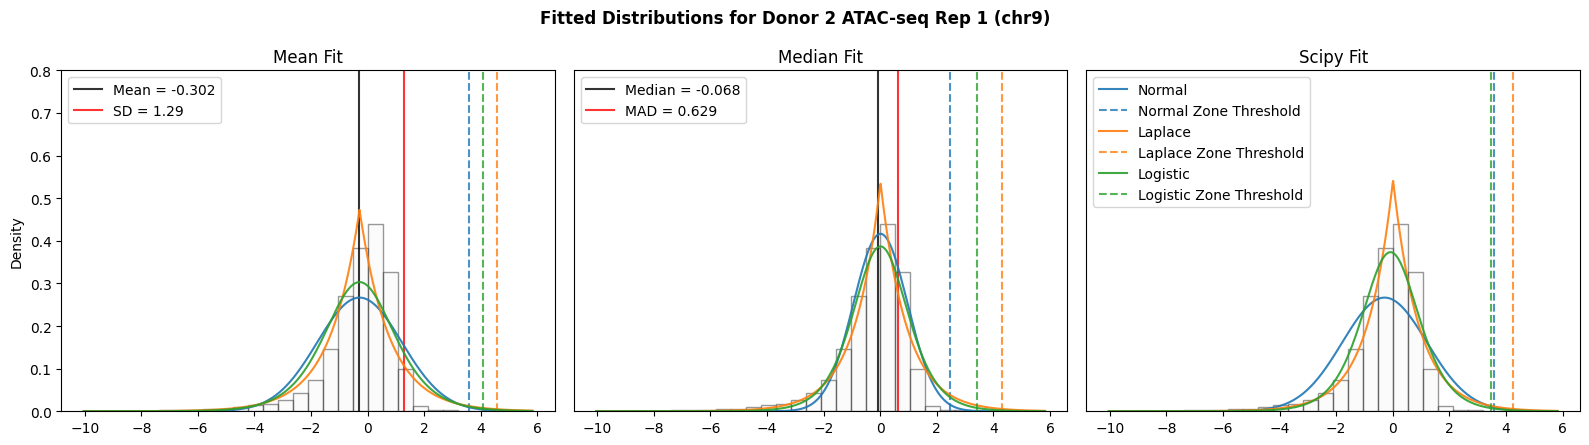

In [38]:
sample_name = "Don002_ATAC_d13_rep1"
chromosome = "chr9"  

# Create distribution plots per sample
ery_atac_znorm.plotDistributionFit(plot_sample = sample_name,
                                   chromosome = chromosome,
                                   plot_distributions = ["normal", "laplace", "logistic"],
                                   plot_param_types = ["mean_fit", "median_fit", "scipy_fit"],
                                   y_limits = [0, 0.8],
                                   plot_width = 16,
                                   plot_height = 4.5,
                                   title = f"Fitted Distributions for Donor 2 ATAC-seq Rep 1 ({chromosome})",
                                   pdf_name = f"{sample_name}_Distributions_{chromosome}")

##### Erythroid RAD21 ChIP-seq Example

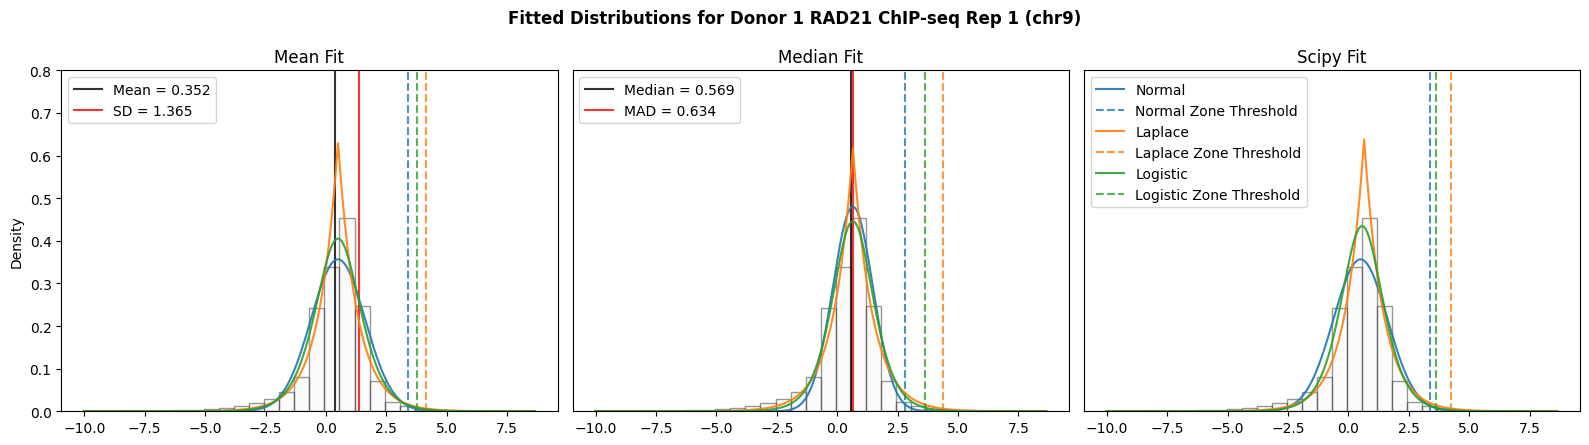

In [39]:
sample_name = "Don001_RAD21_d13_rep1"
chromosome = "chr9"  

# Create distribution plots per sample
rad21_chip_znorm.plotDistributionFit(plot_sample = sample_name,
                                     chromosome = chromosome,
                                     plot_distributions = ["normal", "laplace", "logistic"],
                                     plot_param_types = ["mean_fit", "median_fit", "scipy_fit"],
                                     y_limits = [0, 0.8],
                                     plot_width = 16,
                                     plot_height = 4.5,
                                     title = f"Fitted Distributions for Donor 1 RAD21 ChIP-seq Rep 1 ({chromosome})",
                                     pdf_name = f"{sample_name}_Distributions_{chromosome}")

##### HeLa TT-seq Example

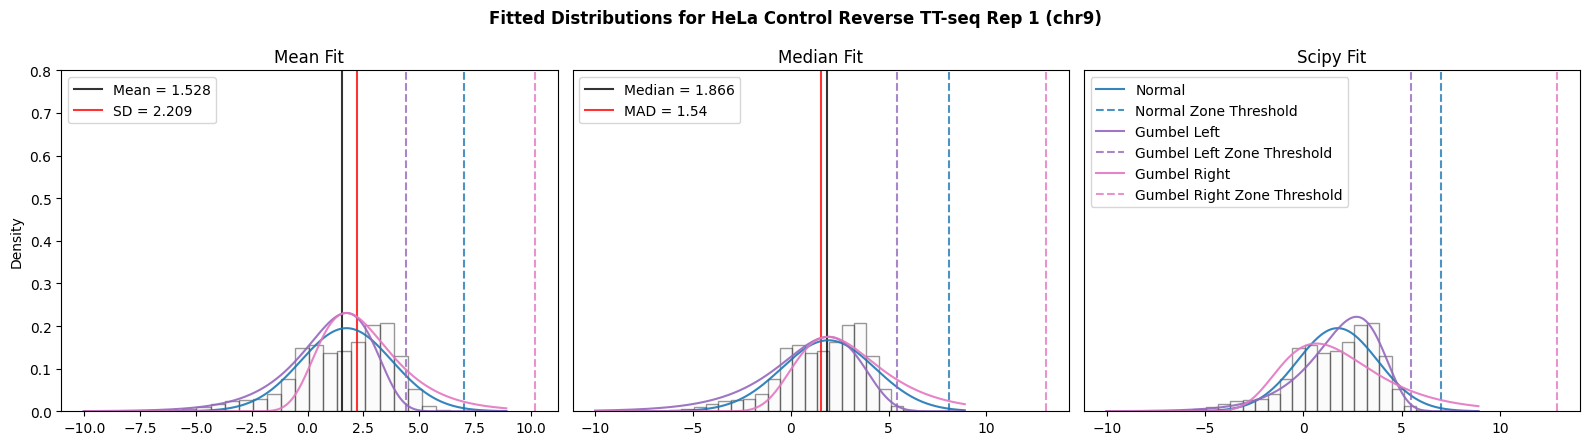

In [40]:
sample_name = "HeLa_TTseq_Control_Rep1_Neg"
chromosome = "chr9"  

# Create distribution plots per sample
hela_ttseq_znorm.plotDistributionFit(plot_sample = sample_name,
                                     chromosome = chromosome,
                                     plot_distributions = ["normal", "gumbel_l", "gumbel_r"],
                                     plot_param_types = ["mean_fit", "median_fit", "scipy_fit"],
                                     y_limits = [0, 0.8],
                                     plot_width = 16,
                                     plot_height = 4.5,
                                     title = f"Fitted Distributions for HeLa Control Reverse TT-seq Rep 1 ({chromosome})",
                                     pdf_name = f"{sample_name}_Distributions_{chromosome}")

#### Visualising the Zone Threshold

Reversing the log transformation of a zone threshold provides the cut off which can directly be applied to the smoothed signal to separate signal from background noise. However, even with the same zone probabilty ($p$), zone thresholds vary both per distribution and selection of location and scale parameters. Additionally, increasing $p$ results in a stricter threshold. The most effective way to see the impact of these parameters before running [Signal Zone Prediction](#run-zen-zones) is to plot part of the smoothed signal along with the zone thresholds. Ideally, to separating signal from background noise, a zone threshold should form a line that sits just above the background. 

##### Investigating How the Distribution Affects the Zone Threshold

The value of the zone threshold for a specific distribution and parameter set can be access via the method `calculateZoneThreshold`.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `sample` | Name of sample to calculate a zone threshold for. | Required. |
| `chromosome` | Name of chromosome. | Required unless custom `location` and `scale` are given. |
| `location` | Value for position of distribution. | Not required, but can be set to calculate the threshold at a custom location instead of the one derrived from distribution fitting. |
| `scale` | Value for distribution spread. | Not required, but can be set to calculate the threshold at a custom scale instead of the one derrived from distribution fitting. |
| `dist_name` | The distribution to derive the thresold from. Options include `norm`, `logistic`, `laplace`, `gumbel_l`, `gumbel_r`, `cauchy`. | Defaults to the set zone distribution. |
| `param_type` | The parameter type for setting the distribution's location and scale. Options include `mean_fit` (mean and SD), `median_fit` (median and MAD), and `scipy_fit` (SciPy's recommended parameters). | Defaults to the set parameter type. |
| `zone_probability` | A probability between 0 and 1 that determines where to place the cutoff relative to the fitted distribution. For example, $p = 0.995$ is the place where 99.5% of the distribution's signal lies to the left of the threshold (or flipped for negative signal). | Defaults to the set zone probability. |

In this case, varying the selected distribution, even while keeping other parameters constant, affects the value of the zone threshold.

In [41]:
# Set colour for each distribution's zone threshold
dist_colour_map = {"norm": "#1f77b4",
                   "laplace": "#ff7f0e",
                   "logistic": "#2ca02c",
                   "gumbel_l": "#9467bd",
                   "gumbel_r": "#e377c2"}

dist_thresholds = []
dist_labels = []
dist_colours = []
param_type = "median_fit"
zone_probability = ery_atac_znorm.getZoneProbability()

for dist in ["norm", "laplace", "logistic"]:
    # Calculate zone threshold for a distribution at a fixed zone probability
    zone_threshold = ery_atac_znorm.calculateZoneThreshold(sample = "Don002_ATAC_d13_rep1", 
                                                           chromosome = "chr16",
                                                           dist_name = dist,
                                                           param_type = param_type, 
                                                           zone_probability = zone_probability)
    # Record the value, a label for the legend and the line colour for the plot below
    dist_thresholds.append(zone_threshold)
    dist_labels.append(f"{dist.title()} Zone Threshold ({param_type.title().replace('_', ' ')}, p = {zone_probability})")
    dist_colours.append(dist_colour_map[dist])

    print(f"The zone threshold for the {dist} distribution with {param_type} and p = {zone_probability} is {zone_threshold}")

The zone threshold for the norm distribution with median_fit and p = 0.995 is 6.496581797475876
The zone threshold for the laplace distribution with median_fit and p = 0.995 is 11.542399388351827
The zone threshold for the logistic distribution with median_fit and p = 0.995 is 9.130080562664158


As the plot below demonstrates, selecting a distribution with a higher threshold reduces the amount of signal that can be predicted as true signal, resulting in fewer regions being distinguished from background noise.

Reading chr16:0-90338345 for Don002_ATAC_d13_rep1


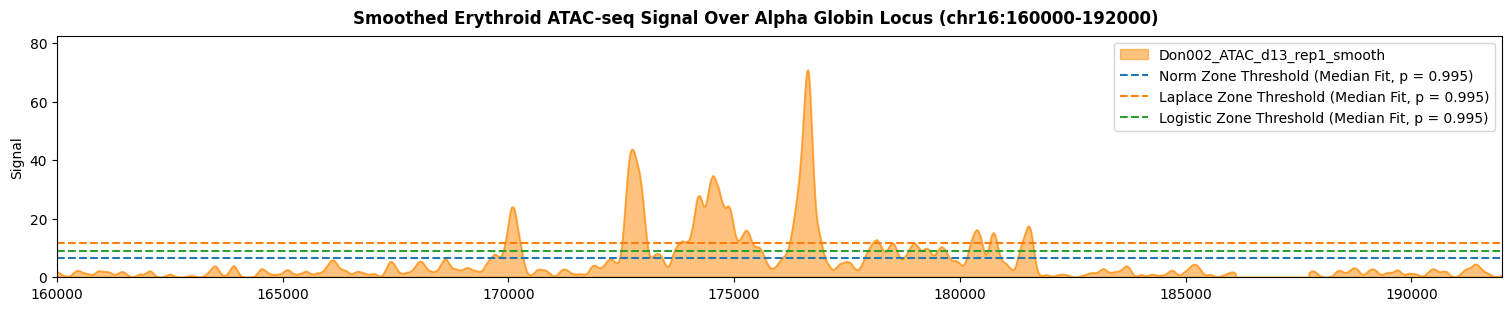

In [42]:
# Get signal after convolution over the alpha globin locus
ery_smooth_signal = ery_atac_znorm.getSmoothedSignal(sample = "Don002_ATAC_d13_rep1", chromosome = hg38_alpha_globin_coords["chrom"])

# Plot the raw signal for two samples 
title = f"Smoothed Erythroid ATAC-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

ery_atac_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                          start_coord = hg38_alpha_globin_coords["start"],
                          end_coord = hg38_alpha_globin_coords["end"],
                          signals = {"Don002_ATAC_d13_rep1_smooth": ery_smooth_signal},
                          custom_colours = ["#FF8800"],
                          overlay_plots = False,
                          main_title = title,
                          y_intercept = dist_thresholds,
                          y_intercept_label = dist_labels,
                          y_intercept_colour = dist_colours)

##### Investigating How the Zone Probability Affects the Zone Threshold

The zone threshold increases with the zone probability $p$.

In [43]:
dist_thresholds = []
dist_labels = []
dist_colours = ["green", "blue", "indigo"]
param_type = "median_fit"
dist_name = "laplace"

for p in [0.99, 0.995, 0.999]:
    # Calculate zone threshold for the same distribution, but at different zone probabilities
    zone_threshold = ery_atac_znorm.calculateZoneThreshold(sample = "Don002_ATAC_d13_rep1", 
                                                           chromosome = "chr16",
                                                           param_type = param_type, 
                                                           dist_name = dist,
                                                           zone_probability = p)
    # Record the value and a label for the legend
    dist_thresholds.append(zone_threshold)
    dist_labels.append(f"{dist.title()} Zone Threshold ({param_type.title().replace('_', ' ')}, p = {p})")

    print(f"The zone threshold for the {dist} distribution with {param_type} and p = {p} is {zone_threshold}")

The zone threshold for the logistic distribution with median_fit and p = 0.99 is 7.883001183382023
The zone threshold for the logistic distribution with median_fit and p = 0.995 is 9.130080562664158
The zone threshold for the logistic distribution with median_fit and p = 0.999 is 12.011981835638807


Configuring $p$ therefore adjusts the acceptable level of background noise. 

Reading chr16:0-90338345 for Don002_ATAC_d13_rep1


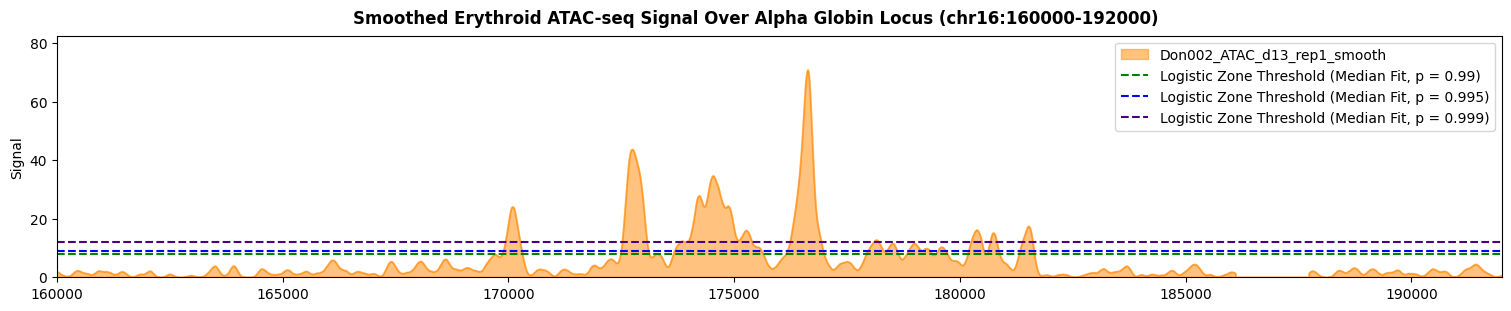

In [44]:
# Get signal after convolution over the alpha globin locus
ery_smooth_signal = ery_atac_znorm.getSmoothedSignal(sample = "Don002_ATAC_d13_rep1", chromosome = hg38_alpha_globin_coords["chrom"])

# Plot the raw signal for two samples 
title = f"Smoothed Erythroid ATAC-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

ery_atac_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                          start_coord = hg38_alpha_globin_coords["start"],
                          end_coord = hg38_alpha_globin_coords["end"],
                          signals = {"Don002_ATAC_d13_rep1_smooth": ery_smooth_signal},
                          custom_colours = ["#FF8800"],
                          overlay_plots = False,
                          main_title = title,
                          y_intercept = dist_thresholds,
                          y_intercept_label = dist_labels,
                          y_intercept_colour = dist_colours)

#### Setting the Distribution to Use

Although the default settings are acceptable to use across different assays and experiments, they can be overridden either during initialisation of a `ZoneNorm` object, or using the following methods.

##### RAD21 ChIP-seq Example

In [45]:
# Set RAD21 ChIP-seq specific parameters based on Q-Q and distribution fit plots
rad21_chip_znorm.setZoneDistribution(zone_distribution = "logistic")
rad21_chip_znorm.setZoneParamType(zone_param_type = "scipy_fit")
rad21_chip_znorm.setZoneProbability(zone_probability = 0.999)

##### HeLa TT-seq Example

In [46]:
# Set HeLa TT-seq specific parameters based on Q-Q and distribution fit plots
hela_ttseq_znorm.setZoneDistribution(zone_distribution = "gumbel_l")
hela_ttseq_znorm.setZoneParamType(zone_param_type = "scipy_fit")

### 5.4) Signal Zone Prediction <a id="run-zen-zones"></a>

After distribution fitting, the zone threshold from the selected distribution is used to create signal zones. These are coordinates for regions enriched in signal over background noise. Four types of zones are generated: unpadded and padded zones, each of which can be sample-specific or merged across samples. The padded sample-specific zones are then used for [Creating Normalised bigWigs](#run-zen-norm).

#### Generating Zone Coordinates

The method `predictSignalZones` uses the parameters of the selected distribution to calculate the zone threshold. This threshold is applied as a cutoff to the smoothed signal, keeping only regions exceeding 35 base pairs. A further quality filter then removes regions with insufficient signal relative to local and global averages. The remaining regions are the unpadded zones. Rounding these to the nearest 1,000 base pairs and adding 1,000 base pairs either side forms the padded zones. 

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `chromosomes` | List or array of chromosomes to predict signal zones for. | By default, all chromosomes are used. Setting a single chromosome, e.g. `["chr19"]`, can be helpful to verify that the step completes successfully. |
| `replace_existing` | If set as `True`, any existing output files generated by this method will be recreated. This is useful if a previous run was interrupted and produced incomplete or corrupt files. If `False` (default), only missing files will be generated without overwriting existing ones. | Use only to recreate files after a previous run. |

##### Erythroid ATAC-seq Example

In [47]:
# Use distribution to predict signal zone coordinates
ery_atac_znorm.predictSignalZones()

Signal and merged zone files already created for chromosomes


##### Erythroid RAD21 ChIP-seq Example

In [48]:
# Use distribution to predict signal zone coordinates
rad21_chip_znorm.predictSignalZones()

Signal and merged zone files already created for chromosomes


##### HeLa TT-seq Example

In [49]:
hela_ttseq_znorm.predictSignalZones()

Signal and merged zone files already created for chromosomes


#### Saving Zones to BED Files <a id="run-zen-zone-bed"></a>

Coordinates of signal zones can be saved to BED files using method `createZoneBED`. These files are required if you want to use these coordinates for [Comparing Normalisation Method Performance Genome-Wide](#norm-compare) or for viewing them in a genome browser.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `zone_type` | Can be set as either `padded` (default) or `unpadded`. | Padded zones are recommended, and for this the parameter can be left unset. |

In [50]:
# Save zone coordinates to BED files
hela_ttseq_znorm.createZoneBED()

Saving zones to BED files


#### Accessing Zone Coordinates

If you want to access the coordinates of signal zones, methods `getSampleZones` and `getMergedZones` can be used.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `chromosome` | Name of the chromosome | Required. |

In [51]:
# Set list of chromosomes to get zone coordinates for
chromosomes = ["chr16"]
# Or use all chromosomes
# chromosomes = ery_atac_znorm.getChromosomes()

sample_zones = {}
merged_zones = {}

for chrom in chromosomes:
    # Get unpadded and padded zone coordinates per sample
    sample_zones[chrom] = ery_atac_znorm.getSampleZones(chromosome = chrom)
    # Get unpadded and padded zone coordinates merged across all samples
    merged_zones[chrom] = ery_atac_znorm.getMergedZones(chromosome = chrom)

In [52]:
# View chromosome 16 padded zone coordinates for a specific sample
print(sample_zones["chr16"]["padded"]["Don002_ATAC_d13_rep1"])

[[    9000    13000]
 [   52000    55000]
 [   95000    99000]
 ...
 [89971000 89974000]
 [90076000 90079000]
 [90081000 90084000]]


In [53]:
# View chromosome 16 padded zone coordinates merged across all samples
print(merged_zones["chr16"]["padded"])

[[    9000    17000]
 [   21000    25000]
 [   48000    56000]
 ...
 [90165000 90171000]
 [90185000 90193000]
 [90214000 90217000]]


#### Visualising Zones

Zones can be plotted as bars above signal using `plotTracks`.

Reading chr16:0-90338345 for Don002_ATAC_d13_rep1
Reading chr16:0-90338345 for Don002_ATAC_d13_rep1


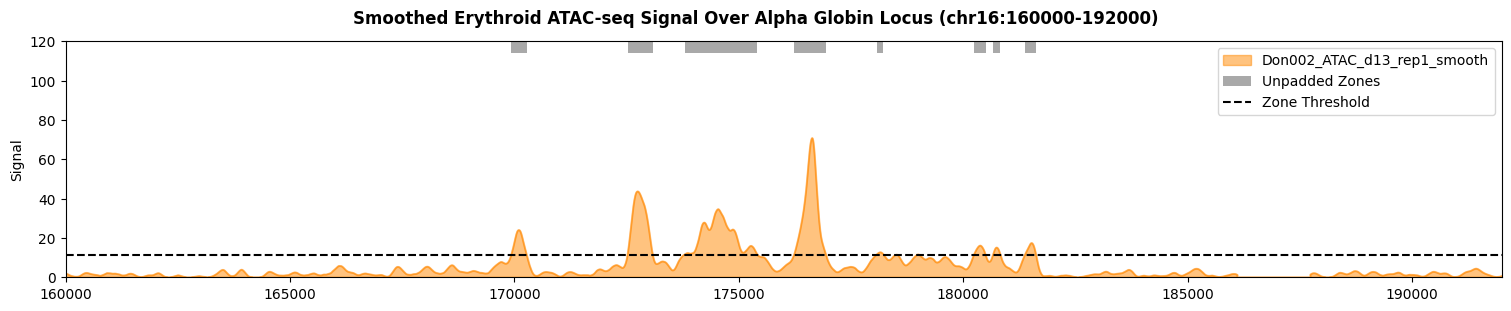

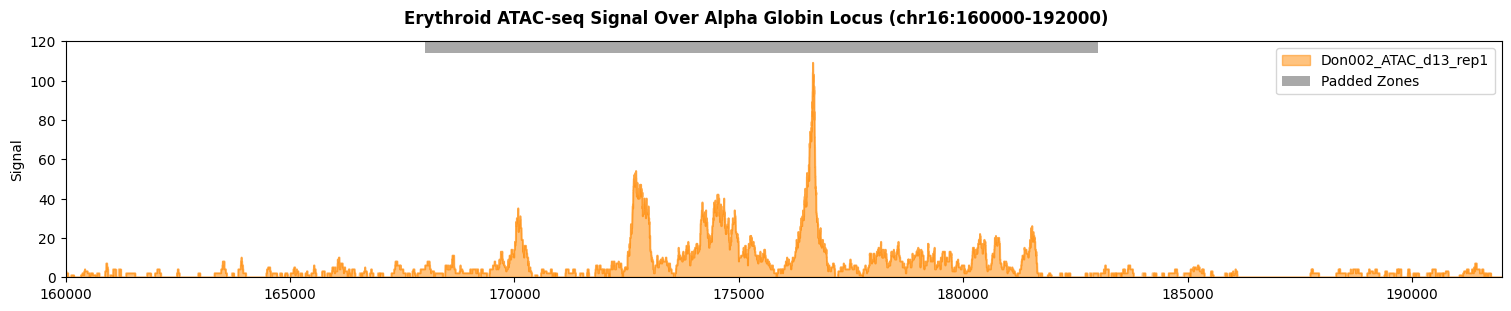

In [54]:
sample_name = "Don002_ATAC_d13_rep1"

# Get the value of the zone threshold from the selected distribution
zone_threshold = ery_atac_znorm.calculateZoneThreshold(sample = sample_name, chromosome = "chr16")

# Get the signal before and after convolution over the alpha globin locus
ery_original_signal = ery_atac_znorm.getOriginalSignal(sample = "Don002_ATAC_d13_rep1", chromosome = hg38_alpha_globin_coords["chrom"])
ery_smooth_signal = ery_atac_znorm.getSmoothedSignal(sample = sample_name, chromosome = hg38_alpha_globin_coords["chrom"])

# Plot the smoothed signal, unpadded zones and zone threshold
title = f"Smoothed Erythroid ATAC-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

ery_atac_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                          start_coord = hg38_alpha_globin_coords["start"],
                          end_coord = hg38_alpha_globin_coords["end"],
                          signals = {"Don002_ATAC_d13_rep1_smooth": ery_smooth_signal},
                          custom_colours = ["#FF8800"],
                          overlay_plots = False,
                          main_title = title,
                          y_intercept = zone_threshold,
                          y_intercept_label = "Zone Threshold",
                          y_intercept_colour = "black",
                          bar_regions = [sample_zones["chr16"]["unpadded"][sample_name]],
                          bar_label = "Unpadded Zones",
                          bar_colour = "darkgrey",
                          custom_y = [0, 120])

# Plot the raw signal and padded zones
title = f"Erythroid ATAC-seq Signal Over Alpha Globin Locus "
title += f"({hg38_alpha_globin_coords['chrom']}:{hg38_alpha_globin_coords['start']}-{hg38_alpha_globin_coords['end']})"

ery_atac_znorm.plotTracks(chromosome = hg38_alpha_globin_coords["chrom"],
                          start_coord = hg38_alpha_globin_coords["start"],
                          end_coord = hg38_alpha_globin_coords["end"],
                          signals = {"Don002_ATAC_d13_rep1": ery_original_signal},
                          custom_colours = ["#FF8800"],
                          overlay_plots = False,
                          main_title = title,
                          bar_regions = [sample_zones["chr16"]["padded"][sample_name]],
                          bar_label = "Padded Zones",
                          bar_colour = "darkgrey",
                          custom_y = [0, 120])

### 5.5) Creating Normalised bigWigs <a id="run-zen-norm"></a>

After predicting signal zones, statistics calculated within these can be used to normalise signal via ZEN. The method `normaliseSignal` performs this over all chromosomes and saves it to bigWigs.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `replace_existing` | If set as `True`, any existing output files generated by this method will be recreated. This is useful if a previous run was interrupted and produced incomplete or corrupt files. If `False` (default), only missing files will be generated without overwriting existing ones. | Use only to recreate files after a previous run. |

##### Erythroid ATAC-seq Example

In [55]:
# Create normalised bigWigs
ery_atac_znorm.normaliseSignal()

Full ZEN normalised signal already created


##### Erythroid RAD21 ChIP-seq Example

In [56]:
# Create normalised bigWigs
rad21_chip_znorm.normaliseSignal()

Full ZEN normalised signal already created


##### HeLa TT-seq Example

In [57]:
# Create normalised bigWigs
hela_ttseq_znorm.normaliseSignal()

Full ZEN normalised signal already created


## 6) Comparing Normalisation Method Performance Genome-Wide <a id="norm-compare"></a>

While signal alignment can be assessed manually by inspecting key loci, the module `CompareNorm` provides a more quantitive approach by calculating statistics representing genome-wide alignment. It supports two plot types: Wasserstein distance plots and MA plots.

### Creating bigWigs With Other Normalisation Methods
Any normalisation method can be compared, provided that bigWigs of normalised signal can be created. The most common bigWig normalisation methods are those supported by deepTools: RPKM, CPM, BPM and RPGC. You may provide your own bigWigs, but the module `ZoneNorm` can also be used to create bigWigs normalised with these methods from BAMs.

In [58]:
# Set names of deepTools normalisation methods
deeptools_norm = ["RPKM", "CPM", "BPM", "RPGC"]
# Include no normalisation and ZEN normalisation
all_norm_methods = ["Raw"] + deeptools_norm + ["ZEN"]

#### Erythroid ATAC-seq Example

`ZoneNorm` can be run in a loop using the same output folder name and BAMs as the example in [BAM to bigWig Mapping](#bam-to-bigwig), but for different normalisation methods. This will create a separate subdirectory for each normalisation method inside the directory containing ZEN-normalised bigWigs (assuming [Running ZEN Normalisation](#run-zen) was run to completion). Note that a genome size must be included to normalise with RPGC.

In [59]:
# Create bigWigs for each normalisation method
for norm in deeptools_norm:
    ZoneNorm(analysis_name = ery_atac_znorm.getAnalysisName(),
             #bam_paths = ery_atac_znorm.getBamPaths(),
             bam_paths = ery_atac_znorm.bam_paths,
             n_cores = cores,
             norm_method = norm,
             extend_reads = True,
             genome_size = "hg38")

Opening 14 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 14 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 14 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 14 bigWig files
Setting chromosomes as autosomal and sex chromosomes


#### Erythroid RAD21 ChIP-seq Example

For the example in [Running ZEN Normalisation](#run-zen), unnormalised bigWigs were used as input. However, here providing BAM paths is essential to run deepTools normalisation methods.

In [60]:
# Create bigWigs for each normalisation method
for norm in deeptools_norm:
    ZoneNorm(analysis_name = rad21_chip_znorm.getAnalysisName(),
             bam_paths = "/ceph/project/Wellcome_Discovery/datashare/towilson/Trackhubs/Human/Erythroid/50_Donors_Erythroid/hg38/E_Georgiades_2025/RAD21/BAMs",
             n_cores = cores,
             norm_method = norm,
             extend_reads = True,
             genome_size = "hg38")

Opening 8 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 8 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 8 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 8 bigWig files
Setting chromosomes as autosomal and sex chromosomes


#### HeLa TT-seq Example

In [61]:
# Create bigWigs for each normalisation method
for norm in deeptools_norm:
    ZoneNorm(analysis_name = hela_ttseq_znorm.getAnalysisName(),
             #bam_paths = hela_ttseq_znorm.getBamPaths(),
             bam_paths = hela_ttseq_znorm.bam_paths,
             n_cores = cores,
             norm_method = norm,
             filter_strand = True,
             extend_reads = False,
             genome_size = "hg38")

Opening 12 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 12 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 12 bigWig files
Setting chromosomes as autosomal and sex chromosomes
Opening 12 bigWig files
Setting chromosomes as autosomal and sex chromosomes


### Creating CSVs Mapping bigWigs to Samples and Coordinates

Module `CompareNorm` requires two input CSVs: one containing the normalised bigWigs, and the other specifying the coordinates to calculate statistics over per sample.

#### BigWig CSV

<ins>Format</ins>

This file maps paths to normalised bigWig with what normalisation method has been applied and which sample they come from.

| norm | sample | bigwig |
|------------|-------------| -------------|
| Normalisation method name | Sample name | Path to bigWig |
| ... | ... | ... |

<ins>Helper Method</ins>

If bigWigs are saved within subfolders in the same directory, a `CompareNorm` method `createBigWigFileCSV` can be used. Otherwise the CSV must be created manually.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| **`sample_names`** | List or array of sample names. | Required. |
| **`bigwig_directory`** | Directory which contains a subfolder for each normalisation method. | Required. |
| **`norm_methods`** | List or array of normalisation methods. Names must match subfolders in `bigwig_directory`, with the exception of `Raw` which assumes a subfolder named `No_Normalisation`. | Required. |
| **`file_extension`** | Either `.bw` or `.bigWig`. | Required. |
| **`csv_file`** | Set as a file name to save the DataFrame to a CSV. | By default, CSV is returned but not saved. |

#### Region Coordinates CSV

This input sets which genomic coordinates to evaluate signal alignment over per sample. It can be specified in one of two ways:

##### Option 1: Regions per sample

<ins>Format</ins>

The first option is to create a CSV file containing paths to peak calls, signal zones (see [Saving Zones to BED Files](#run-zen-zone-bed)) or custom coordinates in BED or narrowPeak format per sample. Sample names must match those in the bigWig CSV to link each bigWig to corresponding coordinates.

| sample | regions |
|------------|-------------|
| Sample name | Path to BED or narrowPeaks file |
| ... | ... |

<ins>Helper Method</ins>

A CSV in the above format can be created using the helper method `createRegionsFileCSV`.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| **`sample_names`** | List or array of sample names, e.g. `["Sample_A", "Sample_B"]`. | Required. |
| **`regions_directory`** | Directory which contains BED or narrowPeak files of coordinates to evaluate alignment over per sample. | Required. |
| **`file_prefix`** | Beginning part of the name of each file, e.g. `padded_zones_` in `padded_zones_sample_A.bed` and `zones_sample_B.bed`. | Set only if file names have a consistent prefix. |
| **`file_postfix`** | End part of the name of each file, e.g. `_peaks` in `sample_A_peaks.narrowPeak` and `zones_sample_peaks.narrowPeak` | Set only if file names have a consistent postfix. |
| **`file_extension`** | Either `.bed` or `.narrowPeak`. | Required. |
| **`csv_file`** | Set as a file name to save the DataFrame to a CSV. | By default, CSV is returned but not saved. |

##### Option 2: Coordinates shared across samples

<ins>Format</ins>

An alternative is to create a CSV of custom coordinates. However, this will use the same coordinates for every sample.

| chrom | start | end |
|------------|-------------|-------------|
| Chromosome name | Start coordinate (indexing starts at 0) | End coordinate |
| ... | ... | ... |

#### Erythroid ATAC-seq Example

The bigWig CSV includes paths to the unnormalised, deepTools normalised and ZEN normalised bigWigs per sample. As ATAC-seq is mostly punctate, the regions CSV is set to use pre-created [LanceOtron](https://github.com/LHentges/LanceOtron) peak calls.

In [62]:
# Create bigWigs CSV
ery_atac_bw_df = CompareNorm.createBigWigFileCSV(sample_names = ery_atac_znorm.getSampleNames(), 
                                                 bigwig_directory = os.path.join(ery_atac_znorm.getOutputDirectory(), "Results", "BigWigs"), 
                                                 norm_methods = all_norm_methods,
                                                 file_extension = ".bw",
                                                 csv_file = "")

# View the bigWig CSV
ery_atac_bw_df

,norm,sample,bigwig
0,Raw,Don002_ATAC_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Proj...
1,Raw,Don002_ATAC_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Proj...
2,Raw,Don002_ATAC_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Proj...
3,Raw,Don002_ATAC_d13_rep4,/ceph/project/Wellcome_Discovery/towilson/Proj...
4,Raw,Don002_ATAC_d13_rep5,/ceph/project/Wellcome_Discovery/towilson/Proj...
...,...,...,...
79,ZEN,Don003_ATAC_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Proj...
80,ZEN,Don003_ATAC_d13_rep4,/ceph/project/Wellcome_Discovery/towilson/Proj...
81,ZEN,Don003_ATAC_d13_rep5,/ceph/project/Wellcome_Discovery/towilson/Proj...
82,ZEN,Don003_ATAC_d13_rep6,/ceph/project/Wellcome_Discovery/towilson/Proj...


In [63]:
# Directory containing LanceOtron peak calls for the erythroid ATAC-seq
ery_atac_peaks_dir = "/ceph/project/Wellcome_Discovery/towilson/Datasets/Human/Erythroid/50_Erythroid_Donors/hg38/Unpublished/ATAC-seq/All_Reads/LanceOtron_Peaks"

# Create regions CSV using the peak calls per sample
ery_atac_regions_df = CompareNorm.createRegionsFileCSV(sample_names = ery_atac_znorm.getSampleNames(),
                                                       regions_directory = ery_atac_peaks_dir,
                                                       file_postfix = "_L-tron",
                                                       file_extension = ".bed",
                                                       csv_file = "")

# View the coordinates CSV
ery_atac_regions_df

,sample,regions
0,Don002_ATAC_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Data...
1,Don002_ATAC_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Data...
2,Don002_ATAC_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Data...
3,Don002_ATAC_d13_rep4,/ceph/project/Wellcome_Discovery/towilson/Data...
4,Don002_ATAC_d13_rep5,/ceph/project/Wellcome_Discovery/towilson/Data...
5,Don002_ATAC_d13_rep6,/ceph/project/Wellcome_Discovery/towilson/Data...
6,Don002_ATAC_d13_rep7,/ceph/project/Wellcome_Discovery/towilson/Data...
7,Don003_ATAC_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Data...
8,Don003_ATAC_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Data...
9,Don003_ATAC_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Data...


#### RAD21 ChIP-seq Example

RAD21 ChIP-seq is mostly punctate, so CSVs are set using all normaliation methods and LanceOtron peak calls.

In [64]:
# Create bigWigs CSV
rad21_chip_bw_df = CompareNorm.createBigWigFileCSV(sample_names = rad21_chip_znorm.getSampleNames(), 
                                                   bigwig_directory = os.path.join(rad21_chip_znorm.getOutputDirectory(), "Results", "BigWigs"), 
                                                   norm_methods = all_norm_methods,
                                                   file_extension = ".bw",
                                                   csv_file = "")

# View the bigWig CSV
rad21_chip_bw_df

,norm,sample,bigwig
0,Raw,Don001_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Proj...
1,Raw,Don001_RAD21_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Proj...
2,Raw,Don001_RAD21_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Proj...
3,Raw,Don002_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Proj...
4,Raw,Don002_RAD21_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Proj...
5,Raw,Don002_RAD21_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Proj...
6,Raw,Don030_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Proj...
7,Raw,Don030_RAD21_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Proj...
8,RPKM,Don001_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Proj...
9,RPKM,Don001_RAD21_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Proj...


In [65]:
# Directory containing LanceOtron peak calls for the RAD21 ChIP-seq
rad21_chip_peaks_dir = "/ceph/project/Wellcome_Discovery/towilson/Datasets/Human/Erythroid/50_Erythroid_Donors/hg38/E_Georgiades_2025/RAD21_ChIP-seq/LanceOtron_Peaks"

# Create regions CSV using the peak calls per sample
rad21_chip_regions_df = CompareNorm.createRegionsFileCSV(sample_names = rad21_chip_znorm.getSampleNames(),
                                                         regions_directory = rad21_chip_peaks_dir,
                                                         file_postfix = "_L-tron",
                                                         file_extension = ".bed",
                                                         csv_file = "")

# View the coordinates CSV
rad21_chip_regions_df

,sample,regions
0,Don001_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Data...
1,Don001_RAD21_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Data...
2,Don001_RAD21_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Data...
3,Don002_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Data...
4,Don002_RAD21_d13_rep2,/ceph/project/Wellcome_Discovery/towilson/Data...
5,Don002_RAD21_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Data...
6,Don030_RAD21_d13_rep1,/ceph/project/Wellcome_Discovery/towilson/Data...
7,Don030_RAD21_d13_rep3,/ceph/project/Wellcome_Discovery/towilson/Data...


#### HeLa TT-seq Example

As TT-seq creates diffuse transcriptional signal, CSVs are set using all normalisation methods and signal zones.

In [66]:
# Create bigWigs CSV
hela_ttseq_bw_df = CompareNorm.createBigWigFileCSV(sample_names = hela_ttseq_znorm.getSampleNames(), 
                                                   bigwig_directory = os.path.join(hela_ttseq_znorm.getOutputDirectory(), "Results", "BigWigs"), 
                                                   norm_methods = all_norm_methods,
                                                   file_extension = ".bw",
                                                   csv_file = "")

# View the bigWig CSV
hela_ttseq_bw_df

,norm,sample,bigwig
0,Raw,HeLa_TTseq_Control_Rep1_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
1,Raw,HeLa_TTseq_Control_Rep1_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
2,Raw,HeLa_TTseq_Control_Rep2_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
3,Raw,HeLa_TTseq_Control_Rep2_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
4,Raw,HeLa_TTseq_Control_Rep3_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
...,...,...,...
67,ZEN,HeLa_TTseq_U1AMO_Rep1_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
68,ZEN,HeLa_TTseq_U1AMO_Rep2_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
69,ZEN,HeLa_TTseq_U1AMO_Rep2_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
70,ZEN,HeLa_TTseq_U1AMO_Rep3_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...


In [67]:
# Create regions CSV using the padded signal zones per sample
hela_ttseq_regions_df = CompareNorm.createRegionsFileCSV(sample_names = hela_ttseq_znorm.getSampleNames(),
                                                         regions_directory = os.path.join(hela_ttseq_znorm.getOutputDirectory(), "Results", "BED", "Zones"),
                                                         file_prefix = "padded_zones_",
                                                         file_extension = ".bed")

# View the coordinates CSV
hela_ttseq_regions_df

,sample,regions
0,HeLa_TTseq_Control_Rep1_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
1,HeLa_TTseq_Control_Rep1_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
2,HeLa_TTseq_Control_Rep2_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
3,HeLa_TTseq_Control_Rep2_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
4,HeLa_TTseq_Control_Rep3_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
5,HeLa_TTseq_Control_Rep3_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
6,HeLa_TTseq_U1AMO_Rep1_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
7,HeLa_TTseq_U1AMO_Rep1_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...
8,HeLa_TTseq_U1AMO_Rep2_Pos,/ceph/project/Wellcome_Discovery/towilson/Proj...
9,HeLa_TTseq_U1AMO_Rep2_Neg,/ceph/project/Wellcome_Discovery/towilson/Proj...


### Specifying Input bigWigs and Region Coordinates

A `CompareNorm` instance is initialised using the bigWig and region coordinates dataframes to determine the input bigWigs signals and coordinates to evaluate alignment over. In addition, several other parameters can be set:

| Parameter | Description | Usage |
|------------|-------------|-------------|
| **`analysis_name`** | Set a custom name for the output folder. | Default to saving results to a folder named `Analysis`. |
| **`bigwig_df`** | How input bigWigs are mapped to the samples they belong to and the normalisation method that was applied. Settable as either a file path to a CSV or as a DataFrame with columns "norm", "sample" and "bigwig", where each row contains the name of the normalisation method, sample name and bigWig path. | Required. |
| **`regions_df`** | To evaluate normalisation performance over regions such as peaks, zones or custom coordinates, set as a DataFrame with columns "sample" and "regions", where regions are given by paths to BED or narrowPeak files. | Required, unless `coords_df` is set. |
| **`coords_df`** | To evaluate normalisation performance over custom coordinates, set as a DataFrame containing "chrom", "start" and "end". Must be given if regions_df is not specified. | Required, unless `regions_df` is set. |
| **`min_peak_score`** | If LanceOtron peaks are given in `regions_df`, this threshold can be set as a value between 0 to 1 to filter peaks by their peak score. A higher value indicates a higher quality threshold and so will filter more peaks. | Only applicable if LanceOtron peaks are input. If not set, no filtering if applied. |
| **`min_consensus`** | For each region, this is the minimum number of samples that a region must be present in for it to be included to evaluate signal alignment per normalisation method. | Defaults to 1 so that all regions are included. Only applicable if `regions_df` was set. |
| **`n_cores`** | The number of processors to use. | Defaults to use only one. |

#### Erythroid ATAC-seq Example

In [68]:
# Specify input bigWigs, peaks and parameters for normalisation method comparision
ery_atac_compare_norm = CompareNorm(analysis_name = ery_atac_znorm.getAnalysisName(),
                                    bigwig_df = ery_atac_bw_df,
                                    regions_df = ery_atac_regions_df,
                                    min_peak_score = 0.5,
                                    min_consensus = 1,
                                    n_cores = cores)

Opening 84 bigWig files


#### RAD21 ChIP-seq Example

In [69]:
# Specify input bigWigs, peaks and parameters for normalisation method comparision
rad21_chip_compare_norm = CompareNorm(analysis_name = rad21_chip_znorm.getAnalysisName(),
                                      bigwig_df = rad21_chip_bw_df,
                                      regions_df = rad21_chip_regions_df,
                                      min_peak_score = 0.5,
                                      min_consensus = 1,
                                      n_cores = cores)

Opening 48 bigWig files


#### HeLa TT-seq Example

In [70]:
# Specify input bigWigs, peaks and parameters for normalisation method comparision
hela_ttseq_compare_norm = CompareNorm(bigwig_df = hela_ttseq_bw_df,
                                      regions_df = hela_ttseq_regions_df,
                                      min_peak_score = 0.5,
                                      min_consensus = 1,
                                      n_cores = cores,
                                      analysis_name = hela_ttseq_znorm.getAnalysisName())

Opening 72 bigWig files


### Wasserstein Distance Plots

Wasserstein distance plots quantify pairwise signal alignment between samples across genomic regions. To compare alignment across normalisation methods regardless of their scale, min-max scaled Wasserstein distance is used. These plots can be created using the method `plotWasserstein`, and are most useful to compare samples whereby signal is expected to be similar, e.g. biological replicates or similar cell types. However, note that these plots can take a while to create if running over many genomic regions and that run time will grow quadratically for every additional sample.

| Parameter | Description | Usage |
|------------|-------------|-------------|
| `plot_samples` | List or array of samples to evaluate pairwise alignment between. | All samples are used if not set. |
| `norm_methods` | List or array of normalisation methods to create violin plots for. | All normalisation methods are used if not set. |
| `chromosomes` | List or array of chromosomes to include in Wasserstein distance calculation over. | All chromosomes are used if not set. |
| `reference_norm` | Specify the name of a normalisation method to compare t-test significance of results against. This is represented on the plot as significance stars. | Not required, but recommended to show significance stars. |
| `use_chrom_maxs` | Set as `True` to use chromosome-wide maximum values when mix-max scaling signal during wasserstein distance calculation or `False` to use the maximum signal value for each coordinate pair. | Defaults to `False`. |
| `log_scale` | Set as `True` to log transform the y-axis. | Defaults to `False`. |
| `plot_type` | Either `violin` or `box` | Defaults to `violin`. |
| `pdf_name` | If provided, the plot will be saved as a PDF file with this name. | By default, plot is displayed but not saved. |

Within a plot, each violin or box represents the distribution of alignment across samples per normalisation method, with lower values indicating better alignment. Bars between the reference normalisation method (if set) and other methods show whether there was a statistically significant difference from a t-test between the two distribution. Violins are coloured by the mean Wasserstein distance across all pairwise measurement per region for the normalisation method.

#### Erythroid ATAC-seq Example

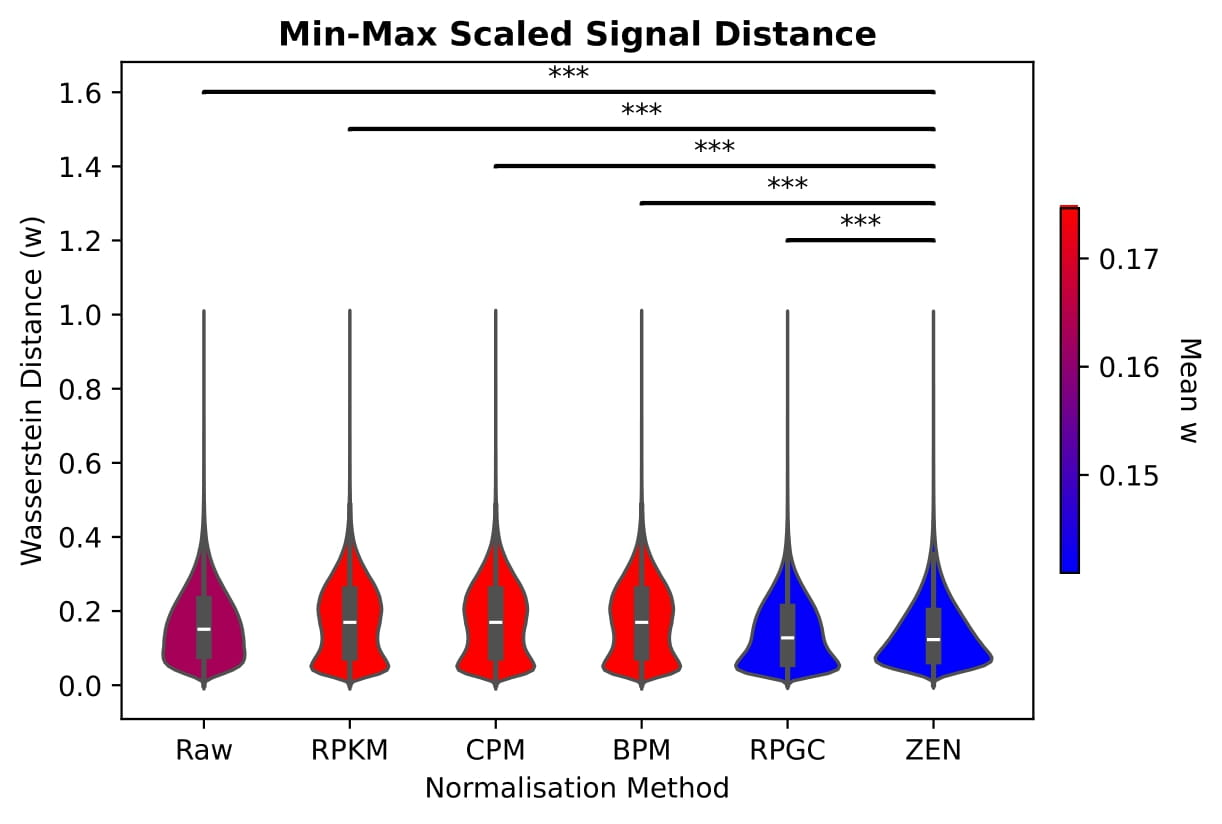

In [89]:
# ery_atac_compare_norm.plotWasserstein(norm_methods = ["Raw", "RPKM", "CPM", "BPM", "RPGC", "ZEN"],
#                                       reference_norm = "ZEN",
#                                       pdf_name = "Erythroid_ATAC_Wasserstein_Plot")
Image(filename="/ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/Erythroid_ATAC/Results/Plots/Erythroid_ATAC_Wasserstein_Plot.jpg", width = 1000) 

#### Erythroid RAD21 ChIP-seq Example

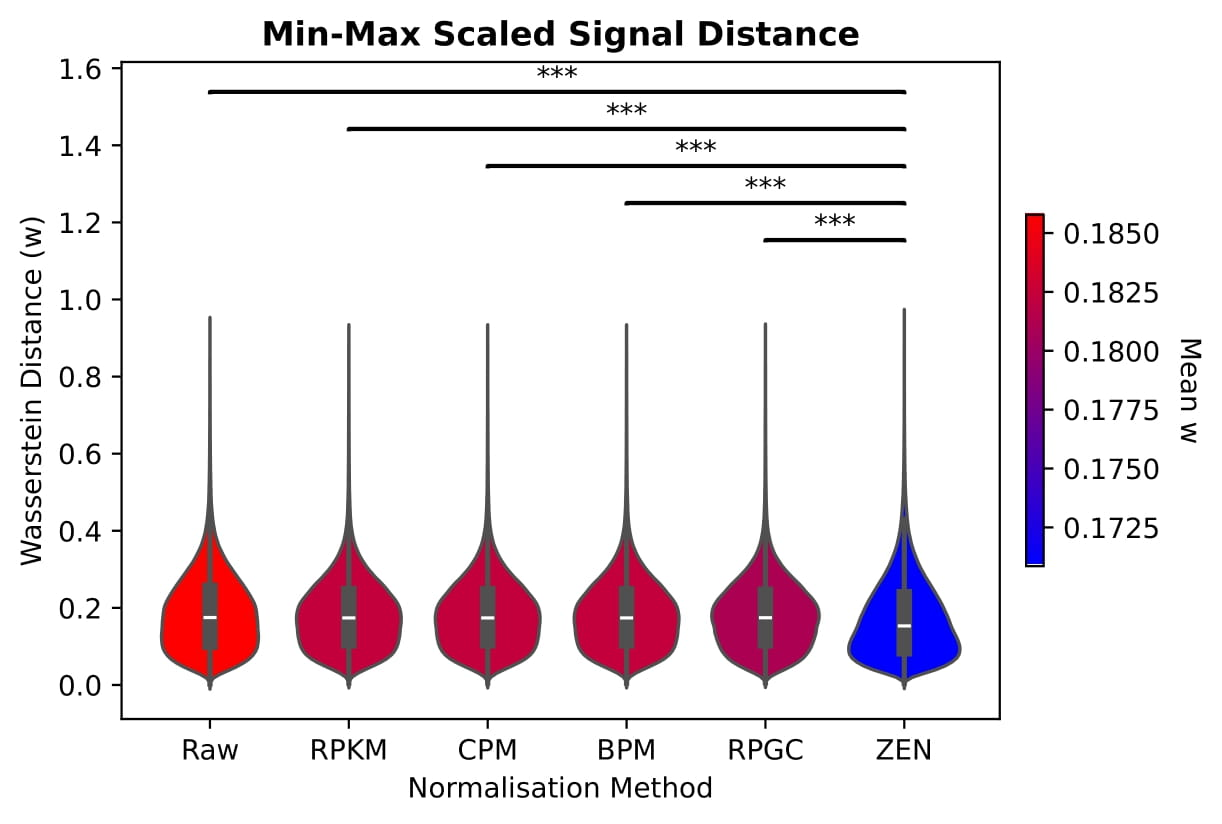

In [93]:
# rad21_chip_compare_norm.plotWasserstein(norm_methods = ["Raw", "RPKM", "CPM", "BPM", "RPGC", "ZEN"],
#                                         reference_norm = "ZEN",
#                                         pdf_name = "Erythroid_RAD21_ChIPseq_Wasserstein_Plot")
Image(filename="/ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/Erythroid_RAD21_ChIPseq/Results/Plots/Erythroid_RAD21_ChIPseq_Wasserstein_Plot.jpg", width = 1000) 

#### HeLa TT-seq Example

In [ ]:
hela_samples_forward = hela_ttseq_compare_norm.regexFindSamples(regex = "Pos", ignore_case = True)
hela_samples_reverse = hela_ttseq_compare_norm.regexFindSamples(regex = "Neg", ignore_case = True)

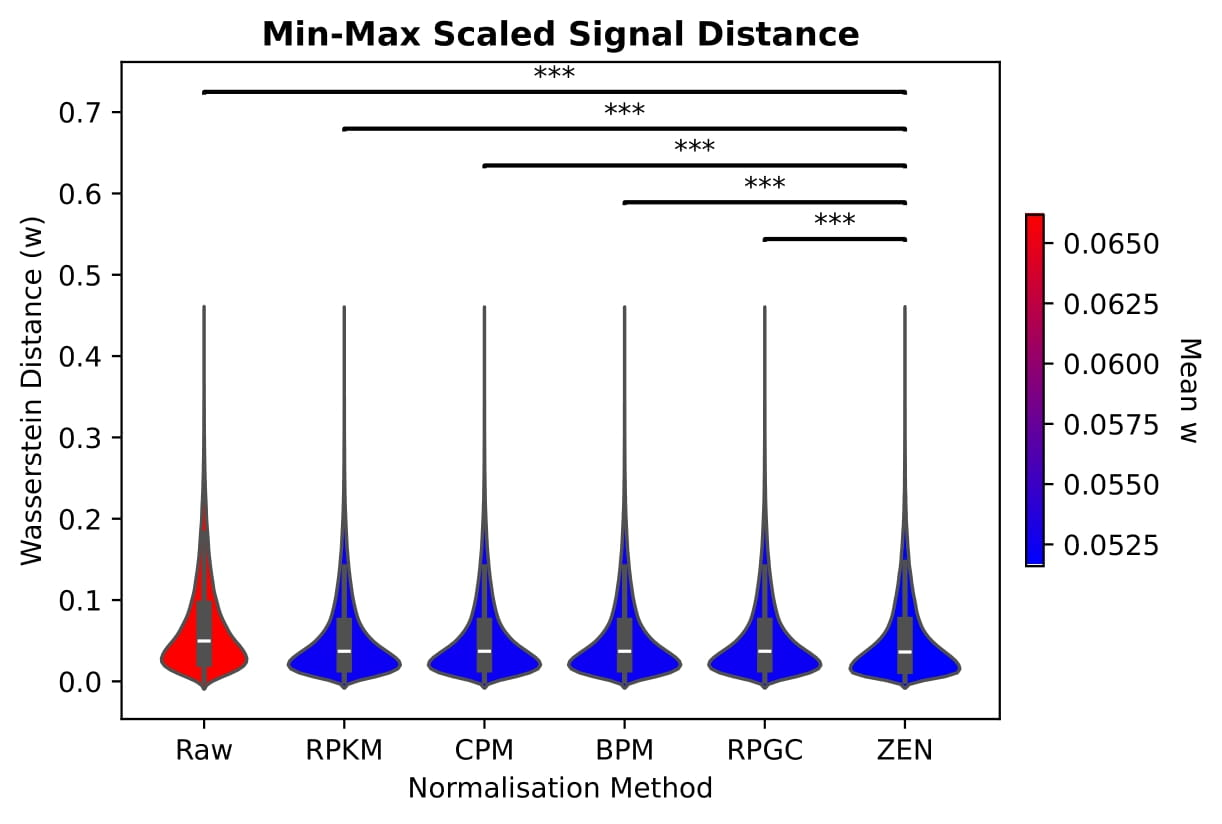

In [94]:
# hela_ttseq_compare_norm.plotWasserstein(plot_samples = hela_samples_forward,
#                                         norm_methods = ["Raw", "RPKM", "CPM", "BPM", "RPGC", "ZEN"],
#                                         reference_norm = "ZEN",
#                                         pdf_name = "HeLa_TTseq_Forward_Wasserstein_Plot")
Image(filename="/ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/HeLa_TTseq/Results/Plots/HeLa_TTseq_Forward_Wasserstein_Plot.jpg", width = 1000) 

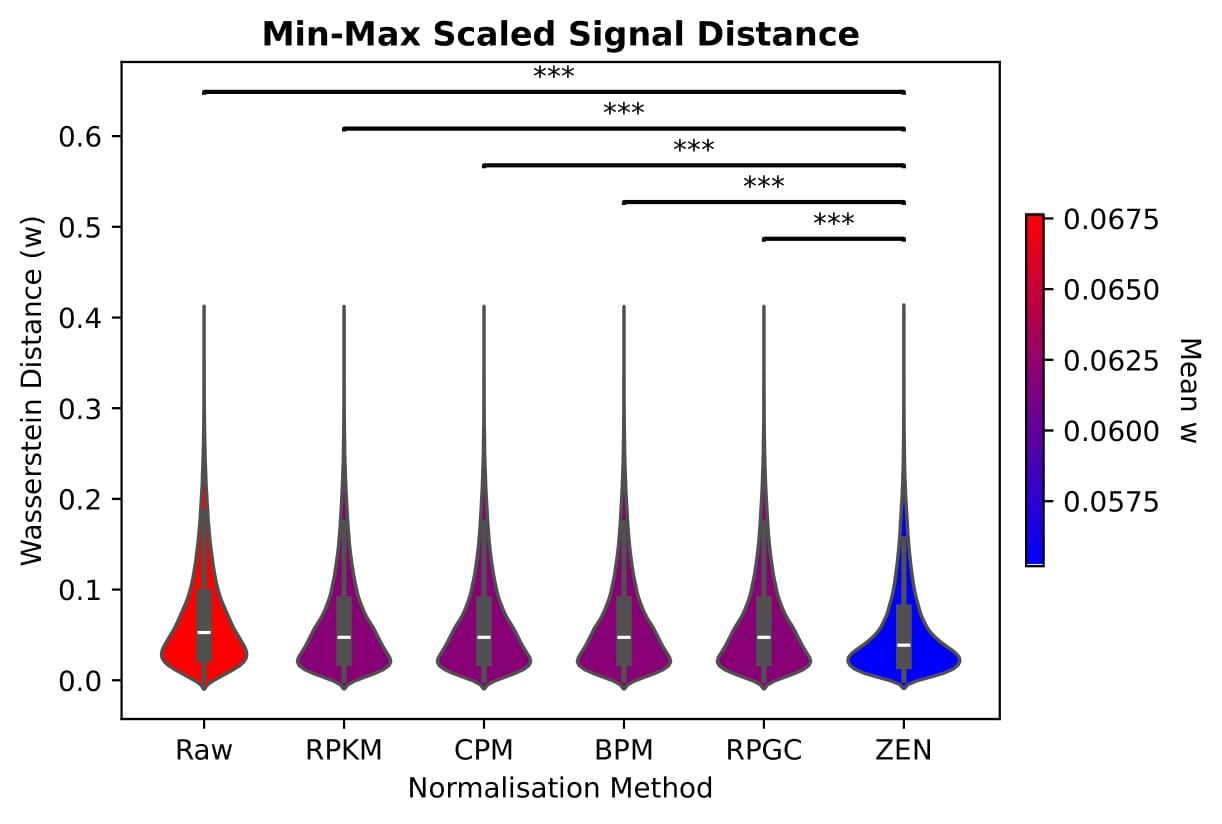

In [95]:
# hela_ttseq_compare_norm.plotWasserstein(plot_samples = hela_samples_reverse,
#                                         norm_methods = ["Raw", "RPKM", "CPM", "BPM", "RPGC", "ZEN"],
#                                         reference_norm = "ZEN",
#                                         pdf_name = "HeLa_TTseq_Reverse_Wasserstein_Plot")
Image(filename="/ceph/project/Wellcome_Discovery/towilson/Projects/ZEN-norm/Package/tests/HeLa_TTseq/Results/Plots/HeLa_TTseq_Reverse_Wasserstein_Plot.jpg", width = 1000) 

### MA Plots

MA plots compare differences in total signal (M) relative to signal intensity (A) between pairs of samples. They can be created using the method `MAPlot`. For samples and regions which are anticipated to be similar, this useful for assessing whether there are biases, e.g. a sample with considerably higher signal than another.
               
| Parameter | Description | Usage
|------------|-------------|-------------|
| `norm_method` | Name of the normalisation method to create the MA plot for. | Required. |
| `plot_samples` | List or array of samples to evaluate pairwise similarity between. | All samples are used if not set. |
| `chromosomes` | List or array of chromosomes to calculate counts per region over. | All chromosomes are used if not set. |
| `title` | Can be set as a custom title. | Defaults to no title. |
| `pdf_name` | If provided, the plot will be saved as a PDF file with this name. | By default, plot is displayed but not saved. |

In each subplot, a point represents the mean count of the signal over a region's coordinates for two samples. The dotted red line is a reference, whereby the closer the points fall, the closer the average counts are for the samples. This therefore gives insight into how effective a normalisation method is at reducing bias.

#### HeLa TT-seq Reverse Strand Example

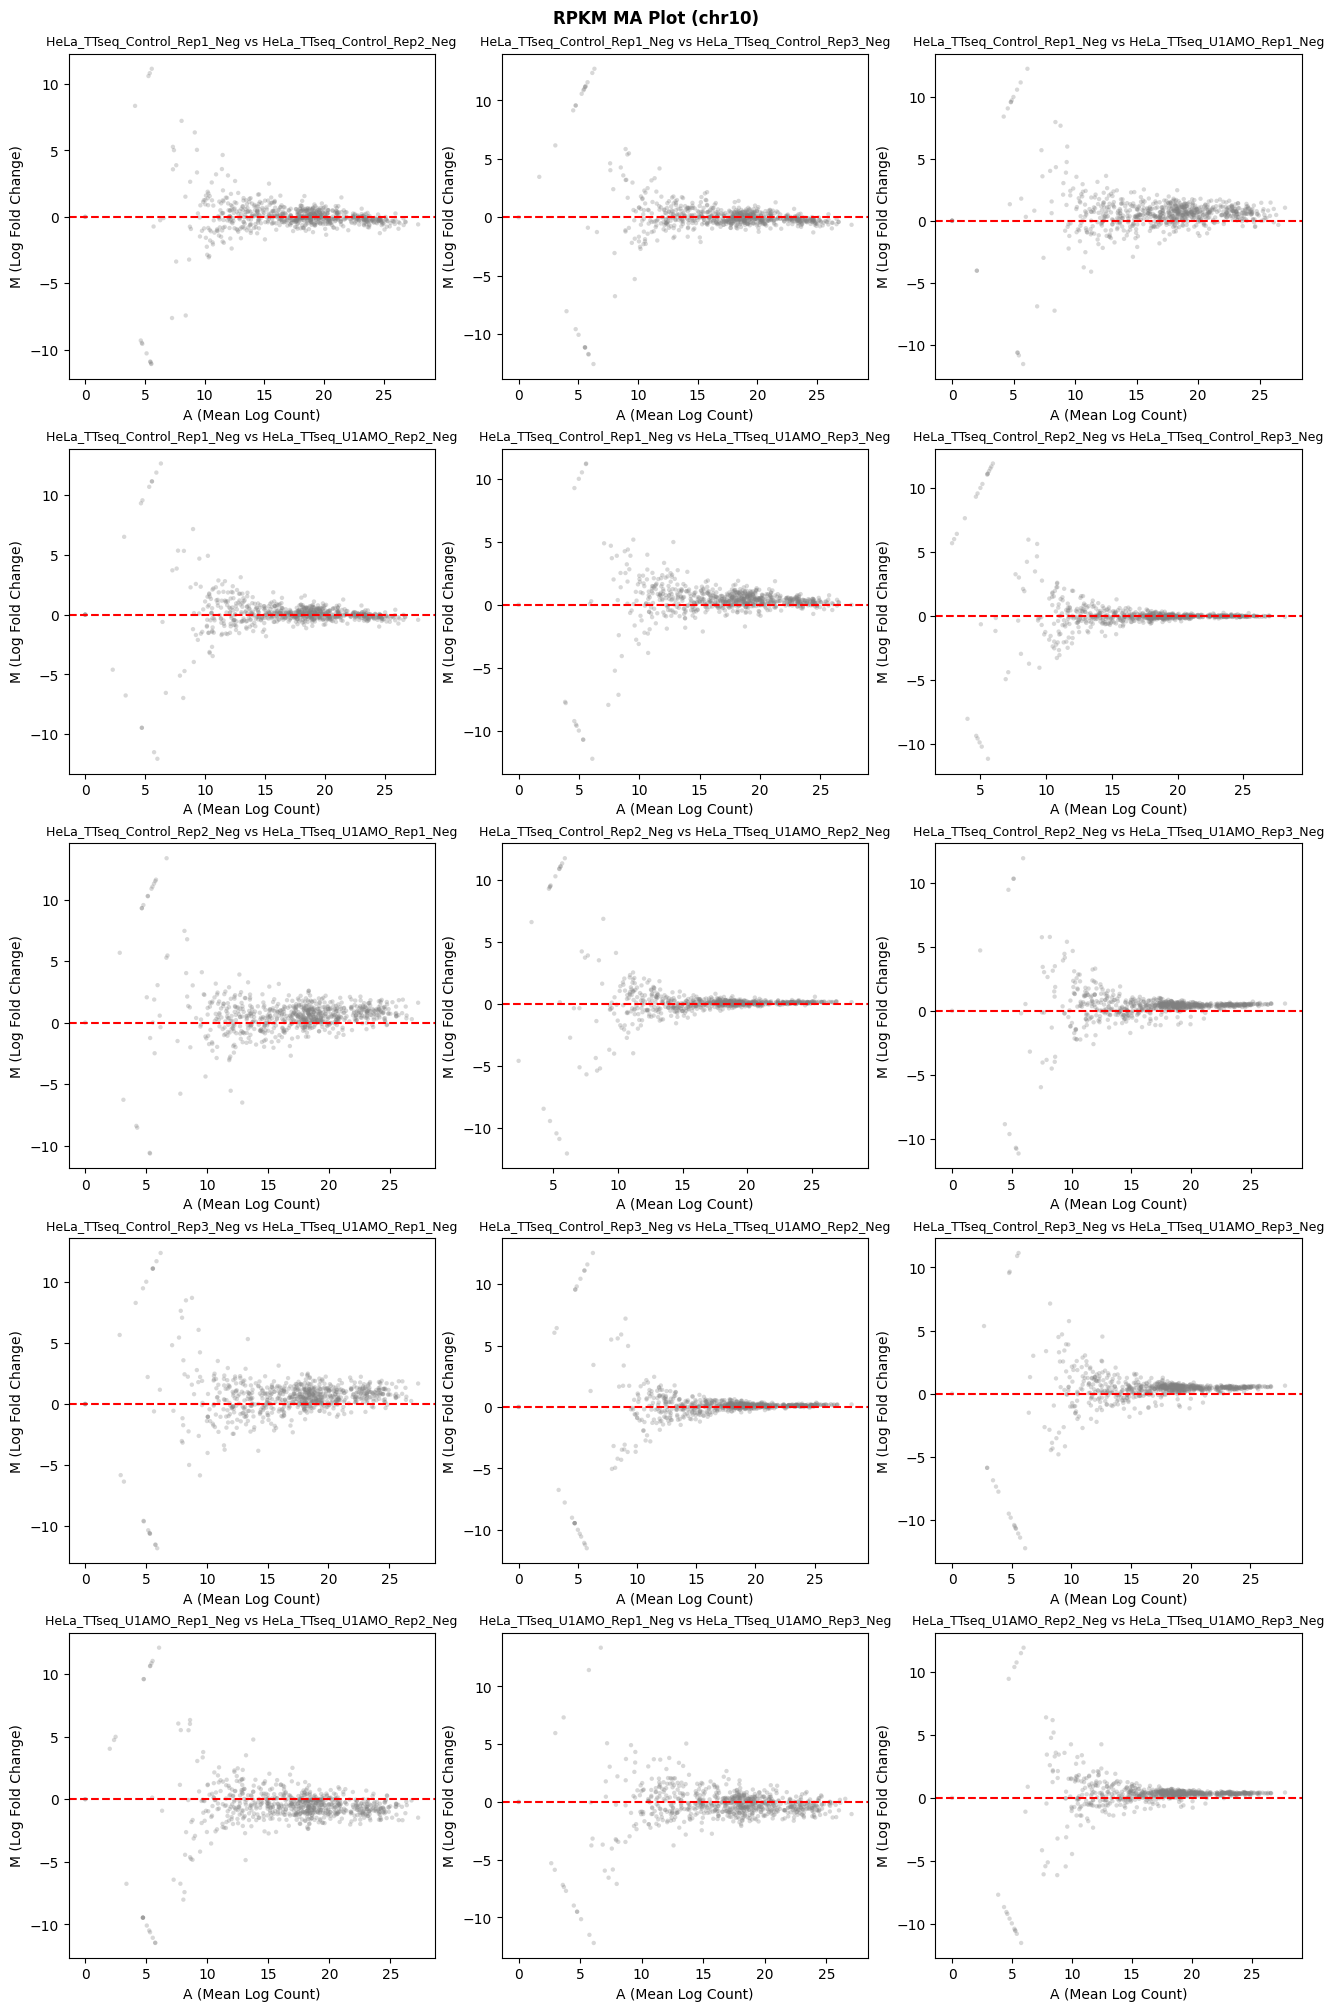

In [72]:
# Find sample names of bigWigs for the reverse strand (sample names end in 'Neg')
hela_samples_reverse = hela_ttseq_compare_norm.regexFindSamples(regex = "Neg", ignore_case = True)

hela_ttseq_compare_norm.MAPlot(norm_method = "RPKM", 
                               plot_samples = hela_samples_reverse, 
                               chromosomes = ["chr10"],
                               n_cols = 3,
                               plot_width = 13,
                               plot_height = 20)